In [3]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit
from numpy.linalg import norm
from sklearn.linear_model import Lasso
from sklearn.datasets import load_svmlight_file
from scipy.io import savemat, loadmat

In [4]:
# have more readable plots with increased fontsize:
fontsize = 16
plt.rcParams.update({'axes.labelsize': fontsize,
              'font.size': fontsize,
              'legend.fontsize': fontsize,
              'xtick.labelsize': fontsize - 2,
              'ytick.labelsize': fontsize - 2})

In [5]:
@njit
def ST(x, u):
    """Soft-thresholding of vector x at level u, i.e., entrywise:
    x_i + u_i if x_i < -u_i, x_i - u_i if x_i > u_i and 0 else.
    """
    return np.sign(x) * np.maximum(0., np.abs(x) - u)

@njit
def rigde_regression(A, b, x, lbda):
    """Value of Least square objective at x."""
    return (1/lbda) * np.mean((A @ x - b) ** 2) + .5*norm(x)


@njit
def lasso_loss(A, b, lbda, x):
    """Value of Lasso objective at x."""
    return norm(A @ x - b) ** 2 / 2. + lbda * norm(x, ord=1)

def logit_log1pexp(x, scalar=True):
    """
    Log(1 + exp(-x)) = logsumexp(0,-x), avoid overflow
    and more accurate than the naive computation.
    https://fa.bianp.net/blog/2019/evaluate_logistic/
    """
    if scalar is True:
        if x < -33.3:
            return -x
        elif x <= -18:
            return np.exp(x) - x
        elif x <= 37:
            return np.log1p(np.exp(-x))
        else:
            return np.exp(-x)
    else:
        out = np.zeros_like(x)
        idx0 = x < -33
        out[idx0] = -x[idx0]
        idx1 = (x >= -33) & (x < -18)
        out[idx1] =  np.exp(x[idx1]) - x[idx1]
        idx2 = (x >= -18) & (x < 37)
        out[idx2] = np.log1p(np.exp(-x[idx2]))
        idx3 = x >= 37
        out[idx3] = np.exp(-x[idx3])
        return out

def logistic(A, b, lbda, x):
    """Value of l1 regularized logistic objective at x."""
    z = A @ x
    return np.mean(logit_log1pexp(b*z, scalar=False)) + lbda * norm(x, ord=1)

@njit
def choose_coord(ndim, n_block,distr='uniform'):
    if distr == 'uniform':
        # i_k = np.random.randint(ndim)
        choices = np.random.choice(ndim, size=n_block, replace=False)
    return choices

def create_mat(dim_row, dim_col, cond_numb, mu=1, uni=False):
    # M = 2*np.random.randn(dim_row, dim_col) + 10
    if uni:
        M = np.random.uniform(-1,1,(dim_row, dim_col))
    else:
        M = np.random.randn(dim_row, dim_col)
    U,b,V=np.linalg.svd(M, full_matrices=False)
    s = b[0] # b is ordered in the decreasing order
    # linear streching of b
    if cond_numb < 1:
        raise ValueError("The condition number should be at least one (>= 1)")
    elif not mu:
        diag = (s-b) / (s-b[-1])
    else:
        diag = cond_numb - (cond_numb-1) * (s-b) / (s-b[-1])
    return U @ np.diag(diag) @ V

def make_data_reg(dim_row, dim_col, cond_numb_A=1, sigma=0, mu=1, uni=False):
    # np.random.seed(0) # The same number will appear every time
    A = create_mat(dim_row, dim_col, cond_numb_A, mu=mu, uni=uni)
    if uni:
        x_star = np.random.randint(-1,1,dim_col)
    else:
        x_star = np.random.randn(dim_col)
    if uni:
        b = A @ x_star + (sigma * np.random.uniform(-1,1,dim_row))
    else:
        b = A @ x_star + (sigma * np.random.randn(dim_row))
    return A, b, x_star

def make_data_class(dim_row, dim_col, cond_numb_A=1, prob_noise=0, mu=1):
    A = create_mat(dim_row, dim_col, cond_numb_A, mu=mu)
    x_star = 5*np.random.randn(dim_col)
    b = np.sign(np.sign(A @ x_star) + .5) # We make sign(0) = 1 instead of the build-in 0.
    if not np.ceil(prob_noise):
        return A, b, x_star
    else:
        prob_list = np.random.choice([0,1], dim_row, [1-prob_noise, prob_noise])
        for i in prob_list:
            if i:
                b[i] = - b[i]
        return A, b, x_star

def delay_vector(max_delay, mdim):
    delay_vect = np.random.choice(max_delay+1, size=mdim)
    return delay_vect

def RBCFB_Lasso(A, b, lbda, max_iter, stepsize_our, stepsize_our_lin, fach_stepsize, wright_stepsize, d_k=None, n_block=1, max_delay=0, delay_fix=False):
    m = A.shape[1]
    
    x_our = np.zeros(m)
    x_our_lin = np.zeros(m)
    x_fach = np.zeros(m)
    x_wright = np.zeros(m)

    fx_our = np.zeros(max_iter)
    fx_our_lin = np.zeros(max_iter)
    fx_fach = np.zeros(max_iter)
    fx_wright = np.zeros(max_iter)

    if max_delay:
        past_x_our = np.zeros((max_delay+1, m))
        past_x_our_lin = np.zeros((max_delay+1, m))
        past_x_fach = np.zeros((max_delay+1, m))
        past_x_wright = np.zeros((max_delay+1, m))

    for t in range(max_iter):
        i = choose_coord(m, n_block)[0]
        if max_delay and not delay_fix:
            d_k = delay_vector(max_delay, m)
            old_x_our = past_x_our.T[np.arange(m),d_k]
            old_x_our_lin = past_x_our_lin.T[np.arange(m),d_k]
            old_x_fach = past_x_fach.T[np.arange(m),d_k]
            old_x_wright = past_x_wright.T[np.arange(m),d_k]
        elif max_delay and delay_fix:
            old_x_our = past_x_our.T[np.arange(m),d_k]
            old_x_our_lin = past_x_our_lin.T[np.arange(m),d_k]
            old_x_fach = past_x_fach.T[np.arange(m),d_k]
            old_x_wright = past_x_wright.T[np.arange(m),d_k]
        else:
            old_x_our = x_our
            old_x_our_lin = x_our_lin
            old_x_fach = x_fach
            old_x_wright = x_wright
        grad_our = A.T @ (A @ old_x_our - b)
        grad_our_lin = A.T @ (A @ old_x_our_lin - b)
        grad_fach = A.T @ (A @ old_x_fach - b)
        grad_wright = A.T @ (A @ old_x_wright - b)
        ###################################################
        grad_i_our = grad_our[i]
        grad_i_our_lin = grad_our_lin[i]
        grad_i_fach = grad_fach[i]
        grad_i_wright = grad_wright[i]
        ###################################################
        # new = ST(x[i] + neg_grad_i / lc[i], lbda / lc[i])
        new_our = ST(x_our[i] - grad_i_our / stepsize_our[i], lbda / stepsize_our[i])
        new_our_lin = ST(x_our_lin[i] - grad_i_our_lin / stepsize_our_lin[i], lbda / stepsize_our_lin[i])
        new_fach = ST(old_x_fach[i] - grad_i_fach / fach_stepsize[i], lbda / fach_stepsize[i])
        new_wright = ST(x_wright[i] - grad_i_wright / wright_stepsize[i], lbda / wright_stepsize[i])
        ##################################################
        x_our[i] = new_our
        x_our_lin[i] = new_our_lin
        x_fach[i] = new_fach
        x_wright[i] = new_wright
        ######################################################
        if max_delay:
            past_x_our[:-1] = past_x_our[1:]
            past_x_our[-1] = x_our.copy()
            past_x_our_lin[:-1] = past_x_our_lin[1:]
            past_x_our_lin[-1] = x_our_lin.copy()
            past_x_fach[:-1] = past_x_fach[1:]
            past_x_fach[-1] = x_fach.copy()
            past_x_wright[:-1] = past_x_wright[1:]
            past_x_wright[-1] = x_wright.copy()
        # all_x[t] = x
        fx_our[t] = lasso_loss(A, b, lbda, x_our)
        fx_our_lin[t] = lasso_loss(A, b, lbda, x_our_lin)
        fx_fach[t] = lasso_loss(A, b, lbda, x_fach)
        fx_wright[t] = lasso_loss(A, b, lbda, x_wright)
    return fx_our, fx_our_lin, fx_fach, fx_wright


def RBCFB_Logistic(A, b, lbda, max_iter, stepsize_our, stepsize_our_lin, fach_stepsize, wright_stepsize, n_block=1, max_delay=0):
    n, m = A.shape
    
    x_our = np.zeros(m)
    x_our_lin = np.zeros(m)
    x_fach = np.zeros(m)
    x_wright = np.zeros(m)
##################################
    fx_our = np.zeros(max_iter)
    fx_our_lin = np.zeros(max_iter)
    fx_fach = np.zeros(max_iter)
    fx_wright = np.zeros(max_iter)
    if max_delay:
        past_x_our = np.zeros((max_delay+1, m))
        past_x_our_lin = np.zeros((max_delay+1, m))
        past_x_fach = np.zeros((max_delay+1, m))
        past_x_wright = np.zeros((max_delay+1, m))

    for t in range(max_iter):
        i = choose_coord(m, n_block)[0]
        if max_delay:
            d_k = delay_vector(max_delay, m)
            old_x_our = past_x_our.T[np.arange(m),d_k]
            old_x_our_lin = past_x_our_lin.T[np.arange(m),d_k]
            old_x_fach = past_x_fach.T[np.arange(m),d_k]
            old_x_wright = past_x_wright.T[np.arange(m),d_k]
        else:
            old_x_our = x_our
            old_x_our_lin = x_our_lin
            old_x_fach = x_fach
            old_x_wright = x_wright
        ywTx_our = b * (A @ old_x_our)
        ywTx_our_lin = b * (A @ old_x_our_lin)
        ywTx_fach = b * (A @ old_x_fach)
        ywTx_wright = b * (A @ old_x_wright)
        ##############################################
        temp_our = 1. / (1. + np.exp(ywTx_our))
        temp_our_lin = 1. / (1. + np.exp(ywTx_our_lin))
        temp_fach = 1. / (1. + np.exp(ywTx_fach))
        temp_wright = 1. / (1. + np.exp(ywTx_wright))
        ##############################
        grad_our = -(A.T @ (b * temp_our)) * 1./n
        grad_our_lin = -(A.T @ (b * temp_our_lin)) * 1./n
        grad_fach = -(A.T @ (b * temp_fach)) * 1./n
        grad_wright = -(A.T @ (b * temp_wright)) * 1./n
        ###################################################
        grad_i_our = grad_our[i]
        grad_i_our_lin = grad_our_lin[i]
        grad_i_fach = grad_fach[i]
        grad_i_wright = grad_wright[i]
        ###################################################
        # new = ST(x[i] + neg_grad_i / lc[i], lbda / lc[i])
        new_our = ST(x_our[i] - grad_i_our / stepsize_our[i], lbda / stepsize_our[i])
        new_our_lin = ST(x_our_lin[i] - grad_i_our_lin / stepsize_our_lin[i], lbda / stepsize_our_lin[i])
        new_fach = ST(old_x_fach[i] - grad_i_fach / fach_stepsize[i], lbda / fach_stepsize[i])
        new_wright = ST(x_wright[i] - grad_i_wright / wright_stepsize[i], lbda / wright_stepsize[i])
        ##################################################
        x_our[i] = new_our
        x_our_lin[i] = new_our_lin
        x_fach[i] = new_fach
        x_wright[i] = new_wright
        ######################################################
        if max_delay:
            past_x_our[:-1] = past_x_our[1:]
            past_x_our[-1] = x_our.copy()
            past_x_our_lin[:-1] = past_x_our_lin[1:]
            past_x_our_lin[-1] = x_our_lin.copy()
            past_x_fach[:-1] = past_x_fach[1:]
            past_x_fach[-1] = x_fach.copy()
            past_x_wright[:-1] = past_x_wright[1:]
            past_x_wright[-1] = x_wright.copy()
        fx_our[t] = logistic(A, b, lbda, x_our)
        fx_our_lin[t] = logistic(A, b, lbda, x_our_lin)
        fx_fach[t] = logistic(A, b, lbda, x_fach)
        fx_wright[t] = logistic(A, b, lbda, x_wright)
    return fx_our, fx_our_lin, fx_fach, fx_wright

In [9]:
A, b = load_svmlight_file("YearPredictionMSD.t")

In [10]:
A = A.toarray()
b = b / A.max()
A = A / A.max()

In [11]:
n,m = A.shape

In [12]:
lbda = 0.01

In [ ]:
l_res = np.max(norm(A.T@A, axis=0))
l_f = l_res
l_max = np.max(norm(A.T@A, ord=np.inf, axis=0)) #np.max(np.max(np.abs(A.T@A), axis=0)))
LMDA = l_res / l_max

rho = (1.0001 + 4/np.sqrt(m)) / (1. - 16./m)

for max_delay in [5, 10, 15, 20]:

    stepsize = .5*( norm(A, axis=0)**2 + (2*max_delay*l_res/np.sqrt(m)) )
    stepsize_lin = .5*( norm(A, axis=0)**2 + (2*max_delay*l_res) )

    fach_stepsize = (l_f + .5*(max_delay**2)*l_f) * np.ones(m)

    theta_reg = (rho**((max_delay+1)/2) - rho**.5) / (rho**.5 - 1)
    theta_prime = (rho**(max_delay+1) - rho) / (rho - 1)
    phi = 1 + max_delay*theta_prime/m + 2*LMDA*theta_reg/(np.sqrt(m))
    tmp =  (4*LMDA*(1+theta_reg)) / (np.sqrt(m)*(1 - 1/rho) - 4)
    wright_stepsize = max(l_max*phi, l_max*tmp)*np.ones(m)

    max_iter = 100000

    all_fx, all_fx_lin, all_fx_fach, all_fx_wright= RBCFB_Lasso(A, b, lbda, max_iter, stepsize, stepsize_lin, fach_stepsize, wright_stepsize, n_block=1, max_delay=max_delay)
    mdic = {"all_fx": all_fx, "all_fx_lin":all_fx_lin, "all_fx_fach":all_fx_fach, "all_fx_wright":all_fx_wright, "tau":max_delay, "label": "Data"}
    savemat(f"data/pred/data_yearpred_train_all_together_{max_delay}.mat", mdic)

In [14]:
l_res = np.max(norm(A.T@A, axis=0))
l_f = l_res
l_max = np.max(norm(A.T@A, ord=np.inf, axis=0)) #np.max(np.max(np.abs(A.T@A), axis=0)))
LMDA = l_res / l_max

rho = (1.0001 + 4/np.sqrt(m)) / (1. - 16./m)

In [15]:
maxi = 100
wright = np.zeros(maxi)
our = np.zeros(maxi)
our_lin = np.zeros(maxi)
fach = np.zeros(maxi)
rho = (1.0001 + 4/np.sqrt(m)) / (1. - 16./m)
# d_k = delay_vector(max_delay, 1)[0]
for tau in np.arange(0,maxi):

    stepsize = .5*( norm(A, axis=0)**2 + (2*tau*l_res/np.sqrt(m)) )

    theta__ = (rho**((tau+1)/2) - rho**.5) / (rho**.5 - 1)
    theta_prime_ = (rho**(tau+1) - rho) / (rho - 1)
    phi_ = 1 + tau*theta_prime_/m + 2*LMDA*theta__/(np.sqrt(m))
    tmp_ =  (4*LMDA*(1+theta__)) / (np.sqrt(m)*(1 - 1/rho) - 4)

    wright[tau] = 1. / max(l_max*phi_, l_max*tmp_)

    fach[tau] = 1. / (l_f + .5*(tau**2)*l_f) #(2*l_f + (tau**2)*l_f)


    our[tau] = np.min(1./(.5*( norm(A, axis=0)**2 + (2*tau*l_res/np.sqrt(m)) )))

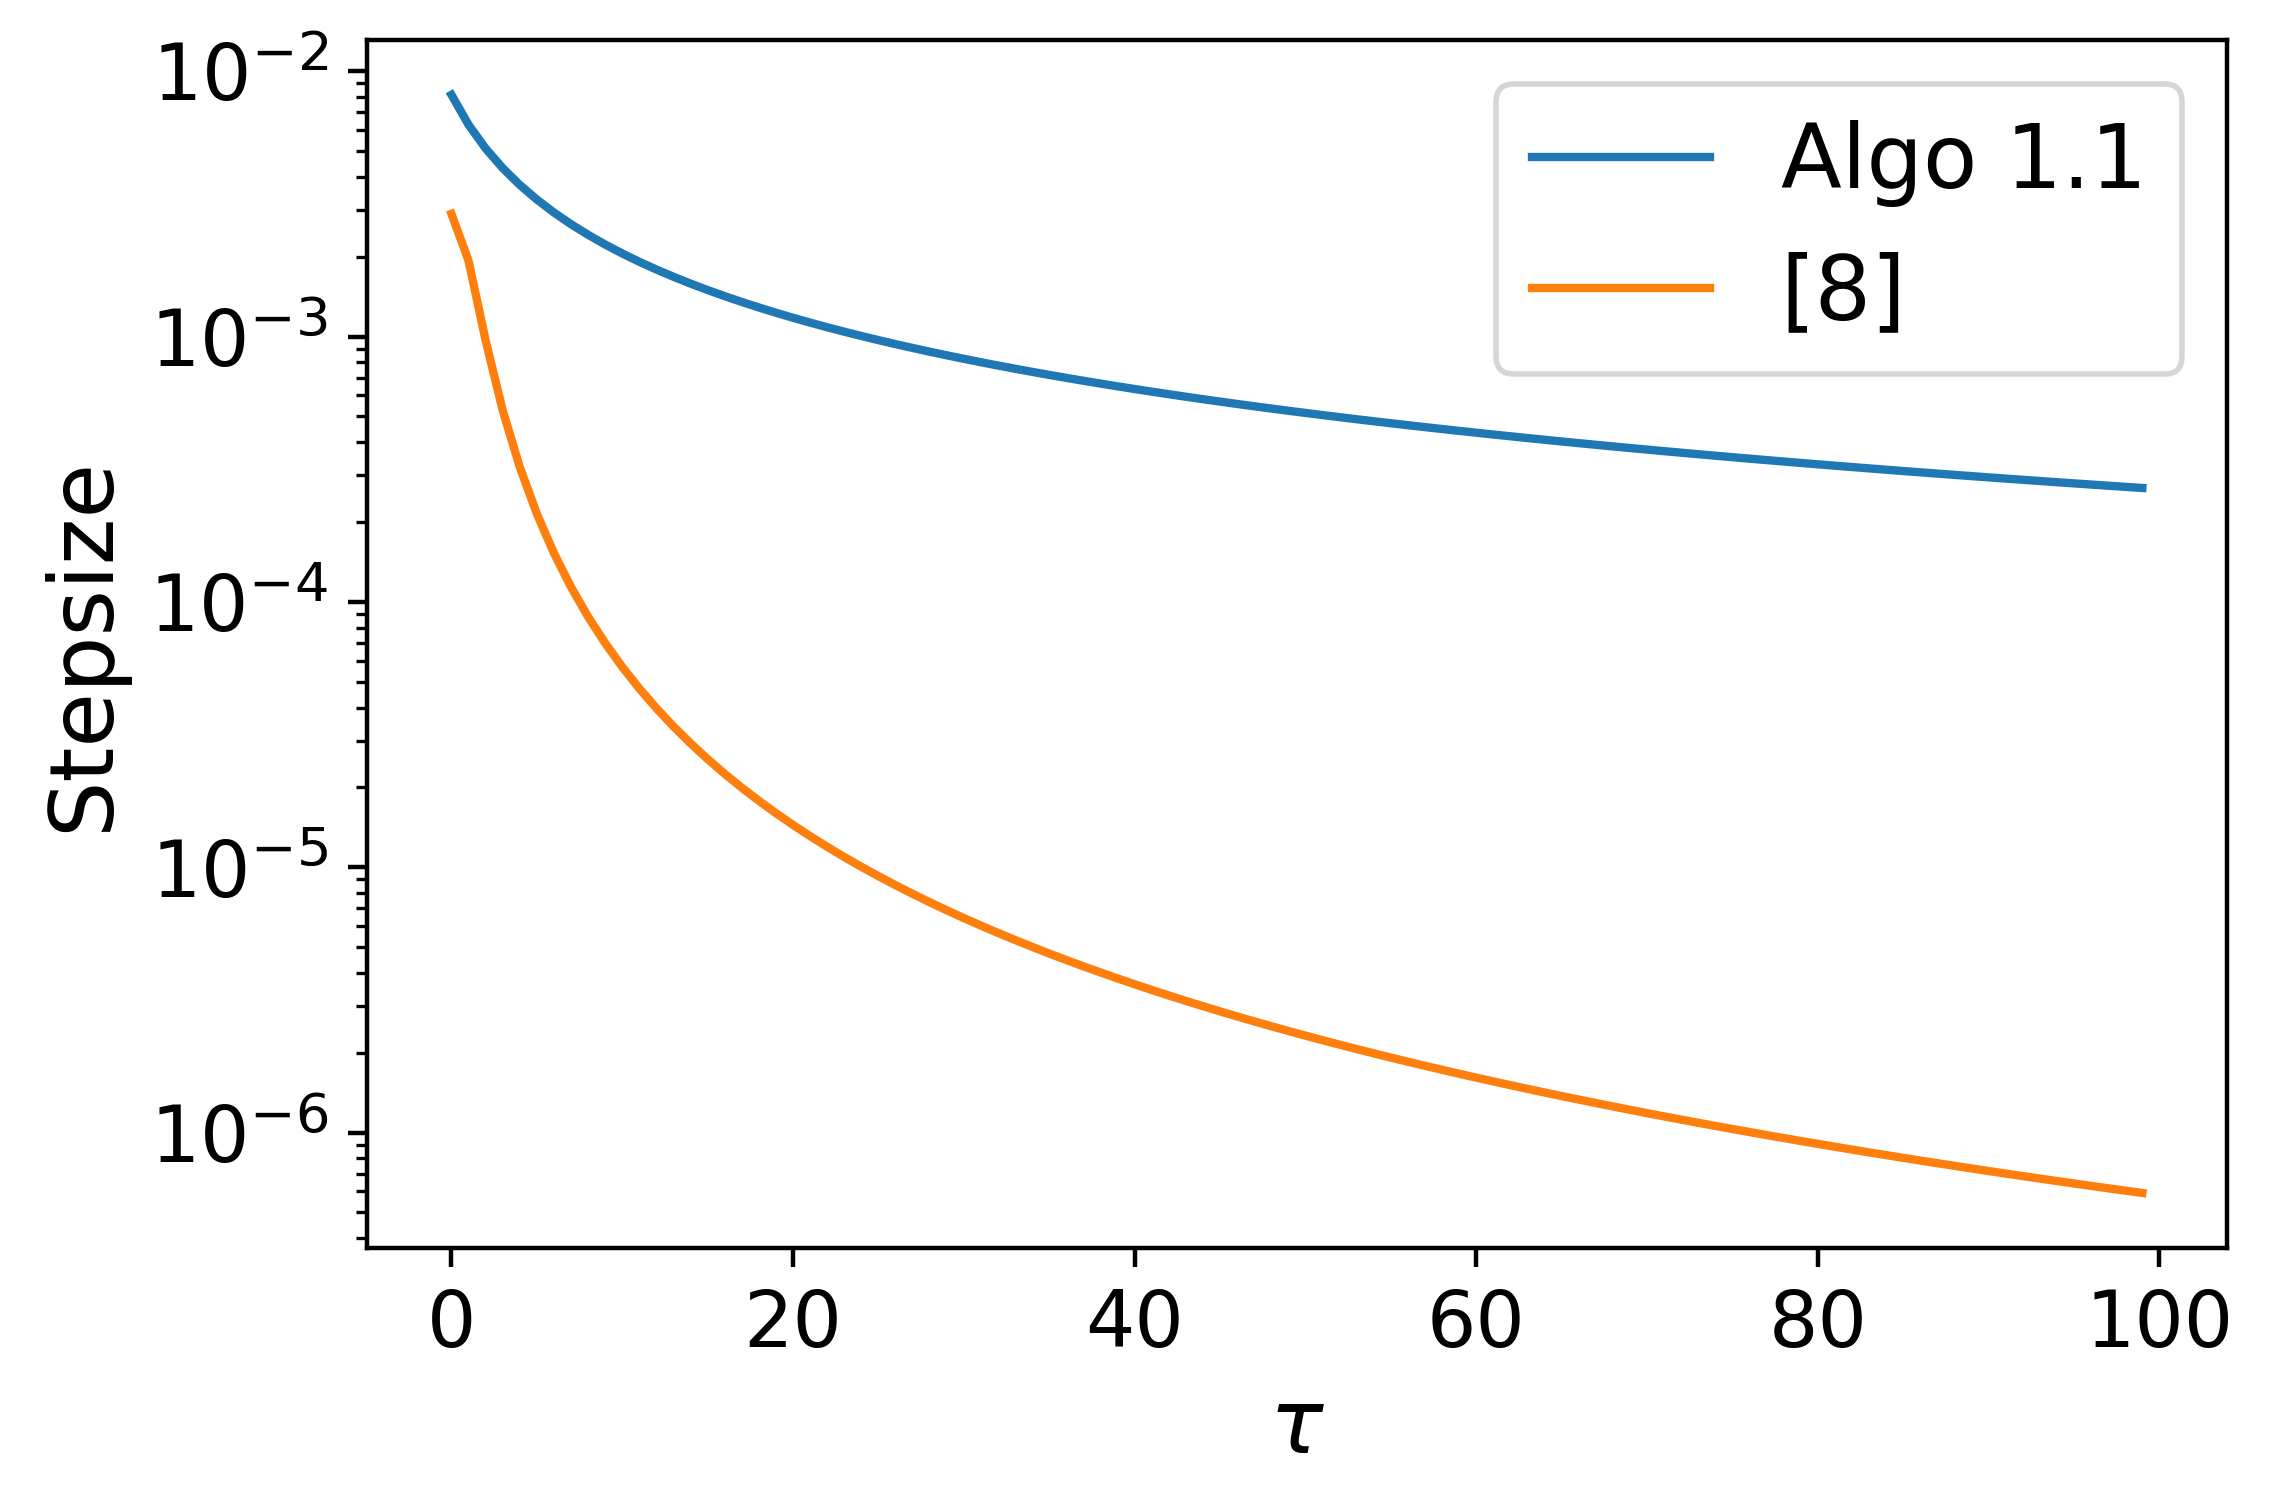

In [16]:
plt.figure(dpi=400)
plt.semilogy(our[:], label=f"Algo 1.1")
plt.semilogy(fach[:], label=f"[8]")
plt.ylabel("Stepsize")
plt.xlabel("$\\tau$")
plt.legend()
plt.savefig(f"dependence_on_tau_cpre_facch", format="png", bbox_inches='tight')

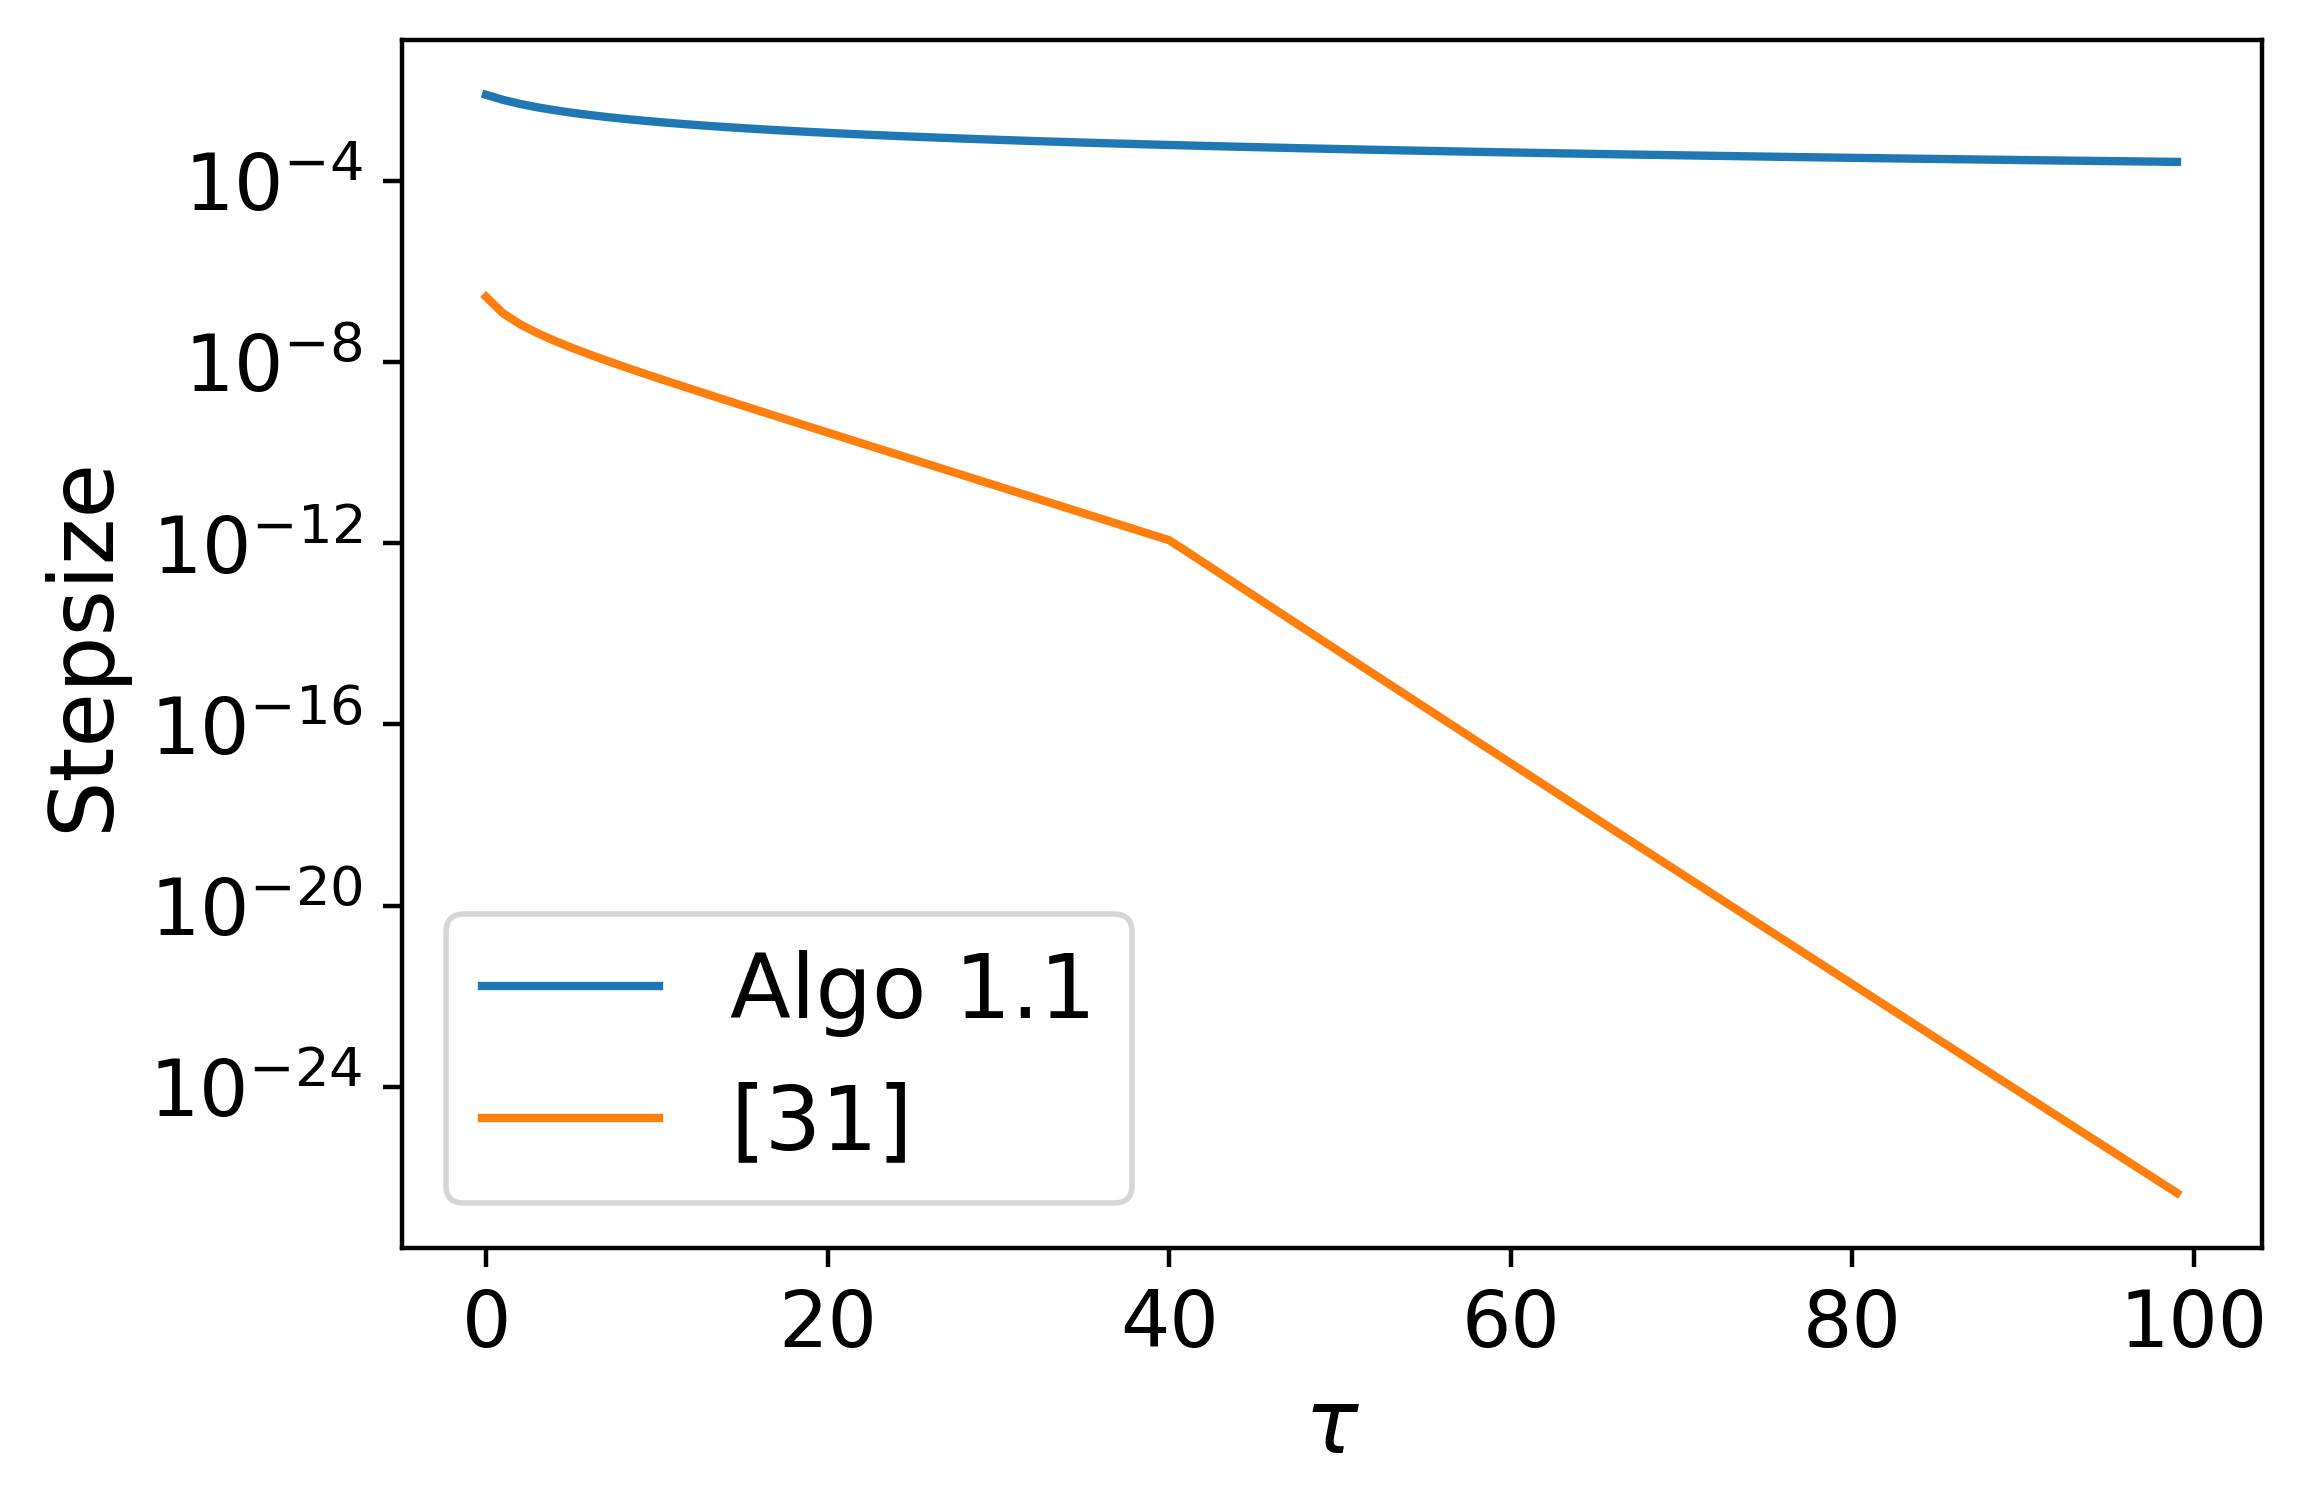

In [18]:
plt.figure(dpi=400)
plt.semilogy(our[:], label=f"Algo 1.1")
plt.semilogy(wright[:], label=f"[31]")
plt.ylabel("Stepsize")
plt.xlabel("$\\tau$")
plt.legend()
plt.savefig(f"dependence_on_tau_cpre_wright", format="png", bbox_inches='tight')

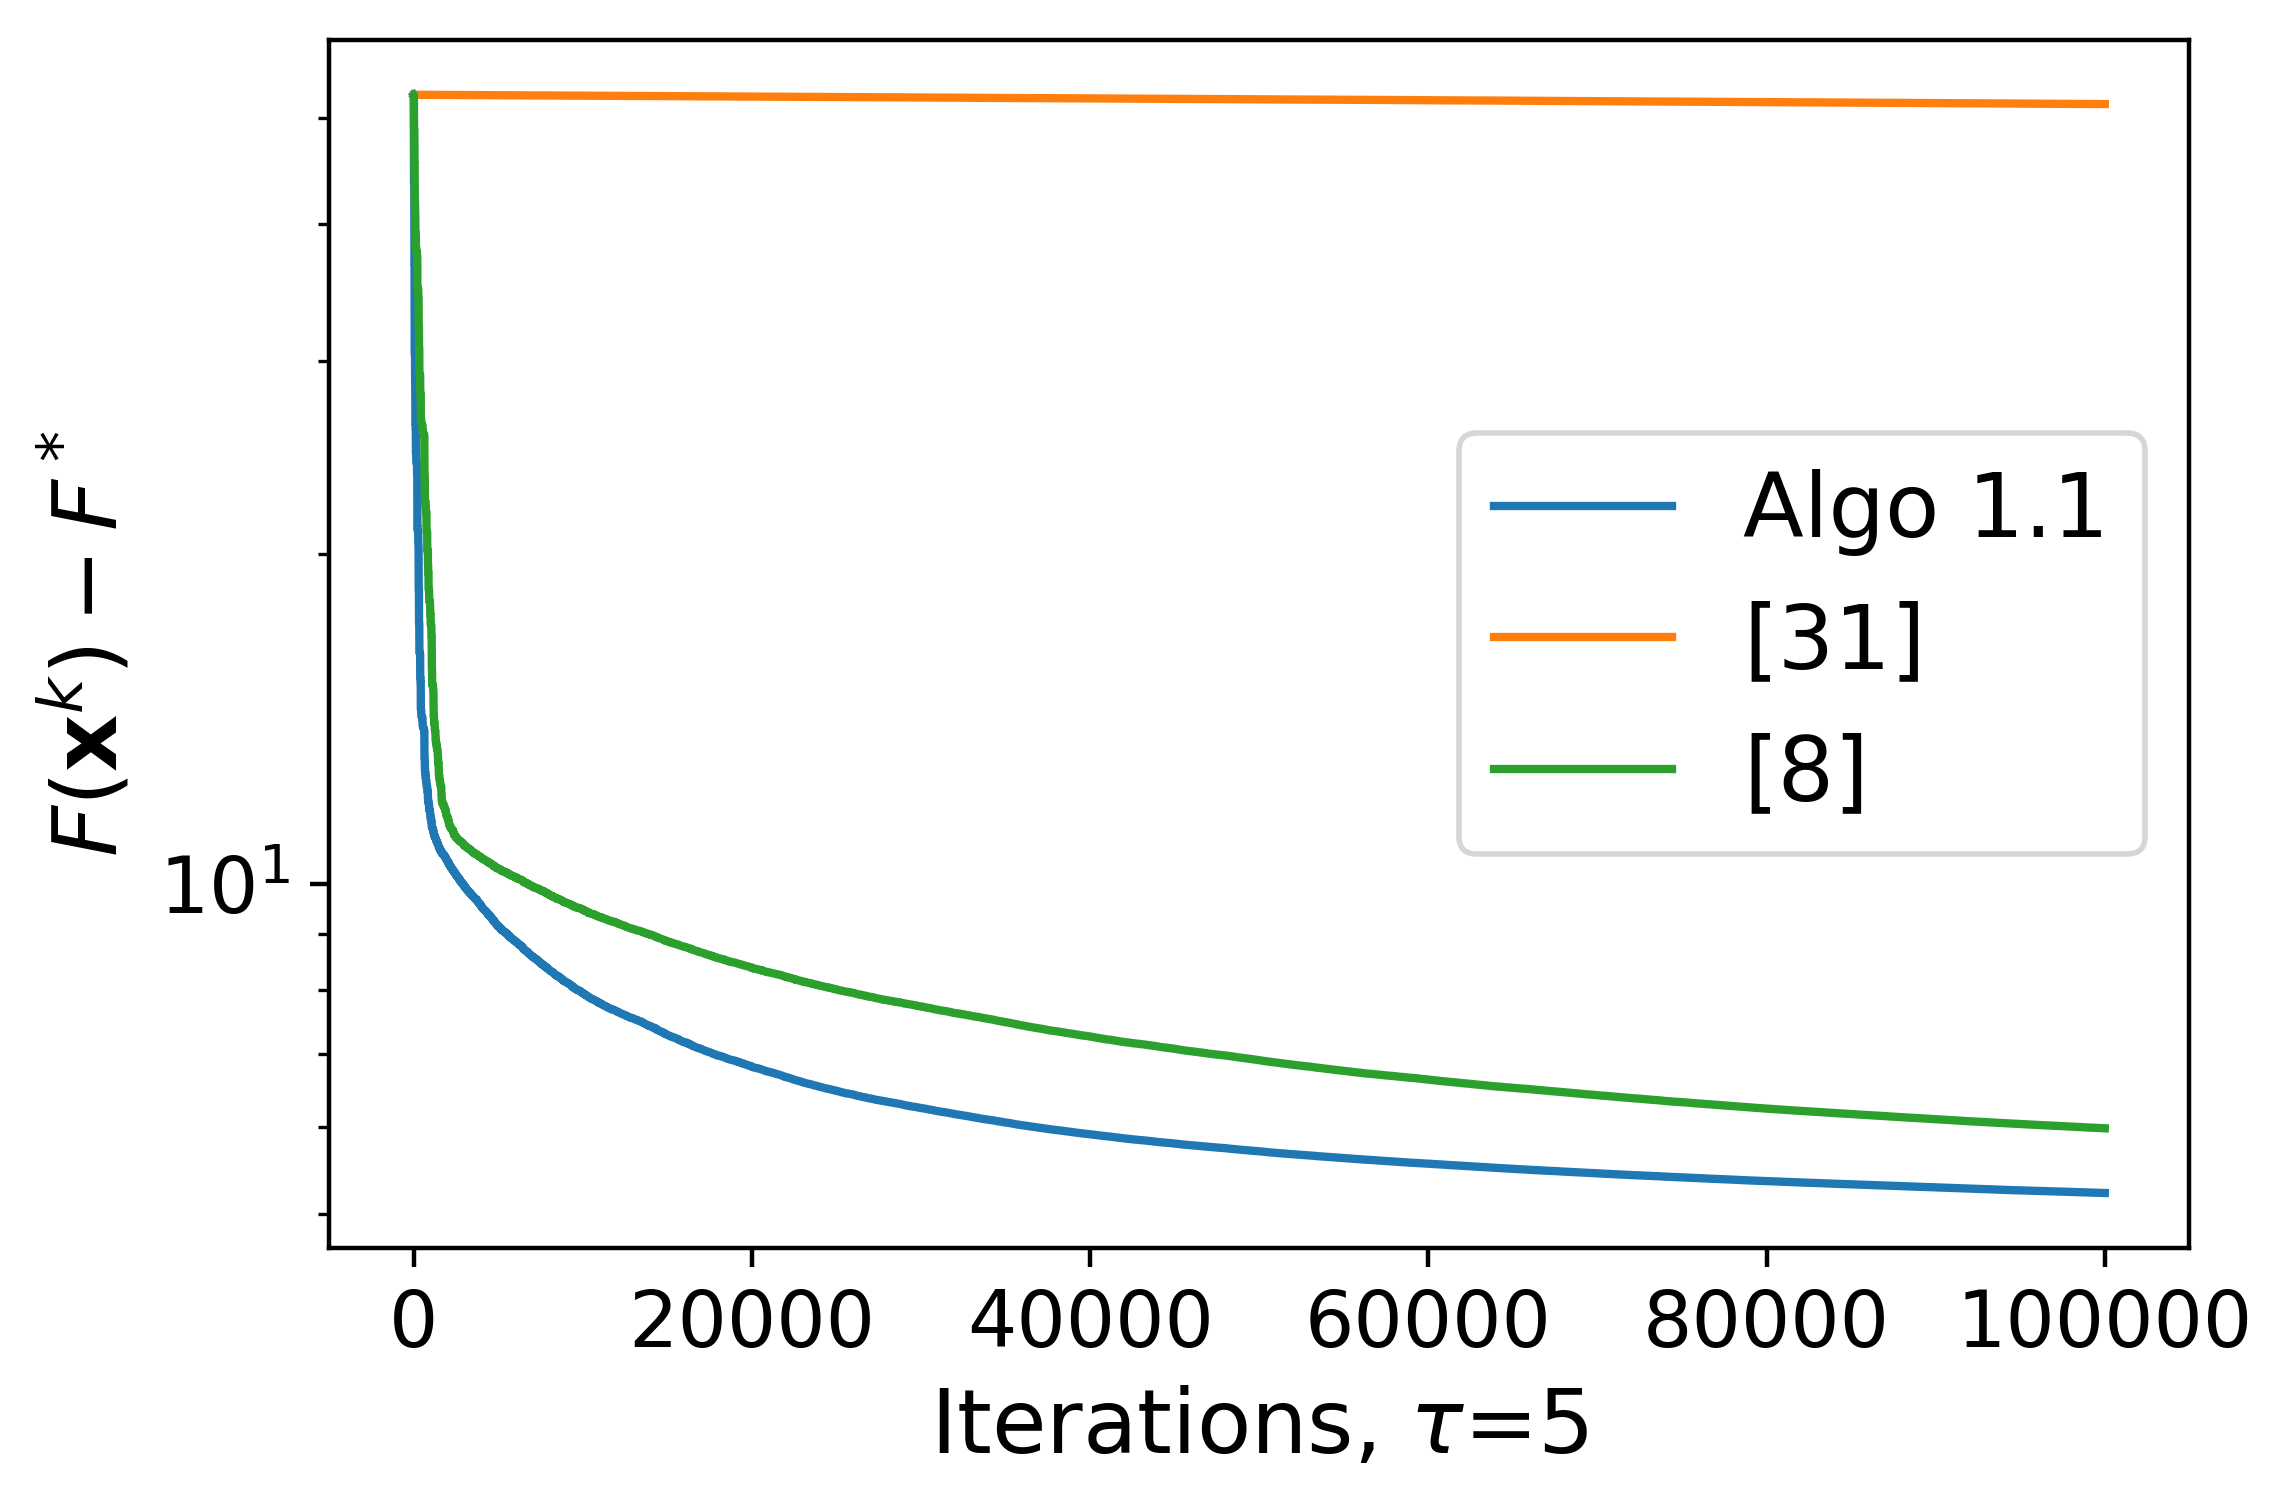

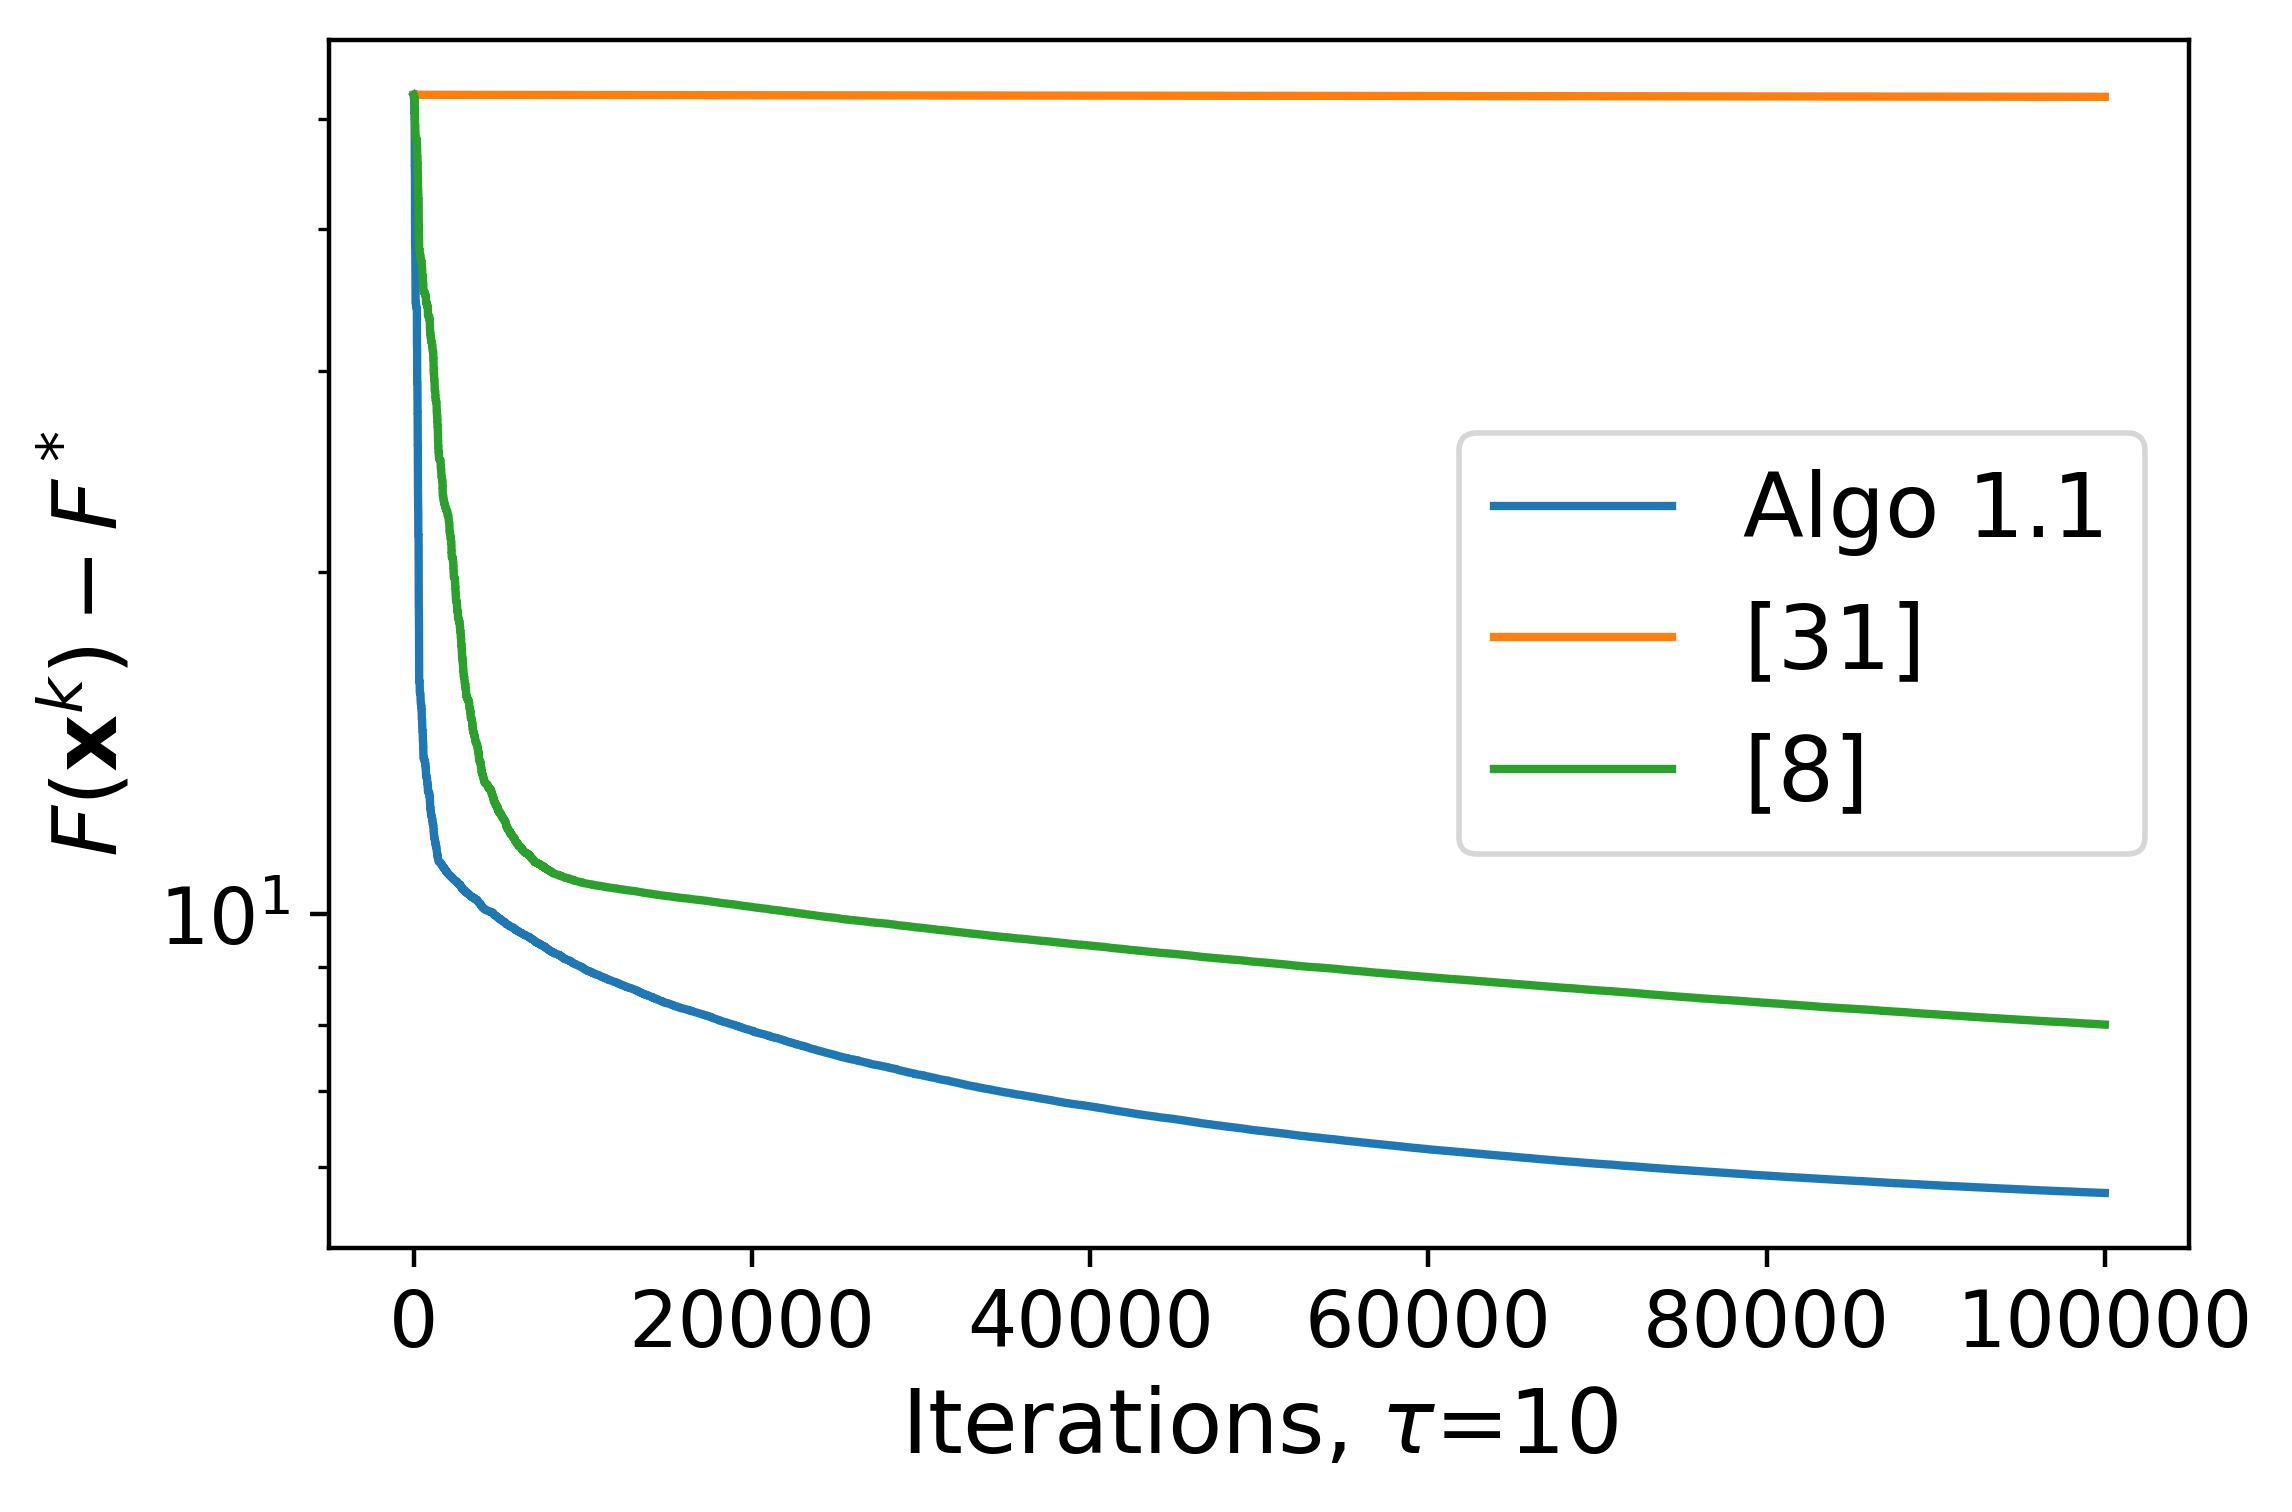

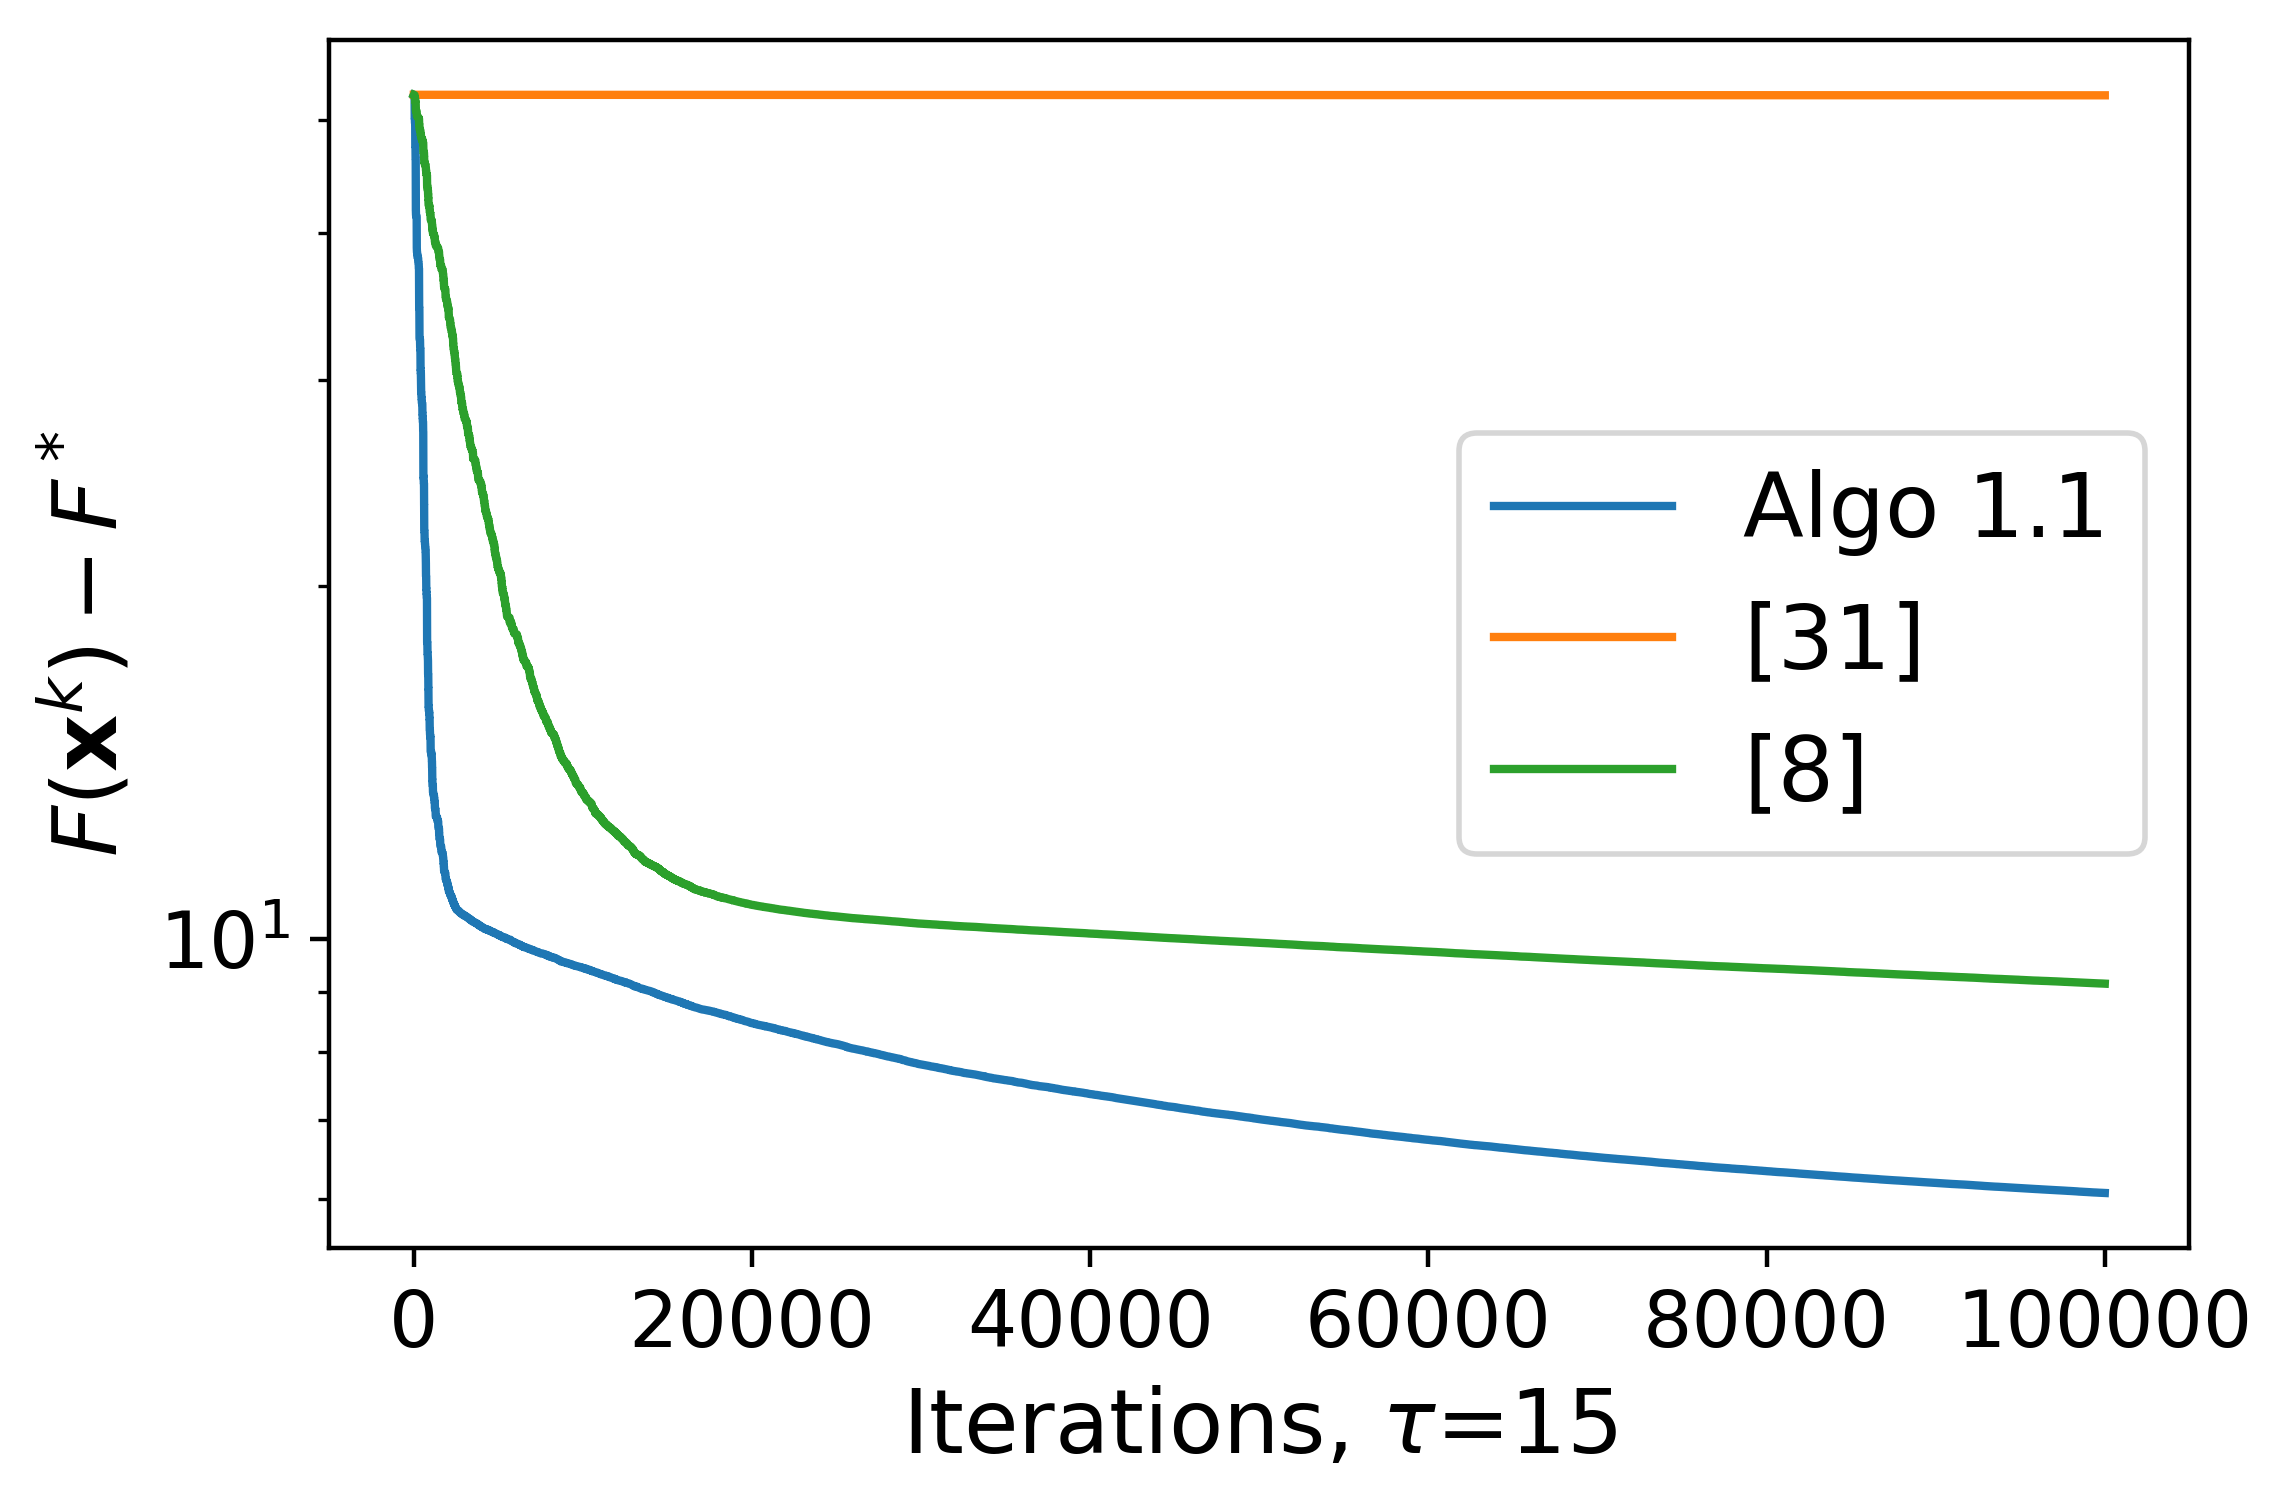

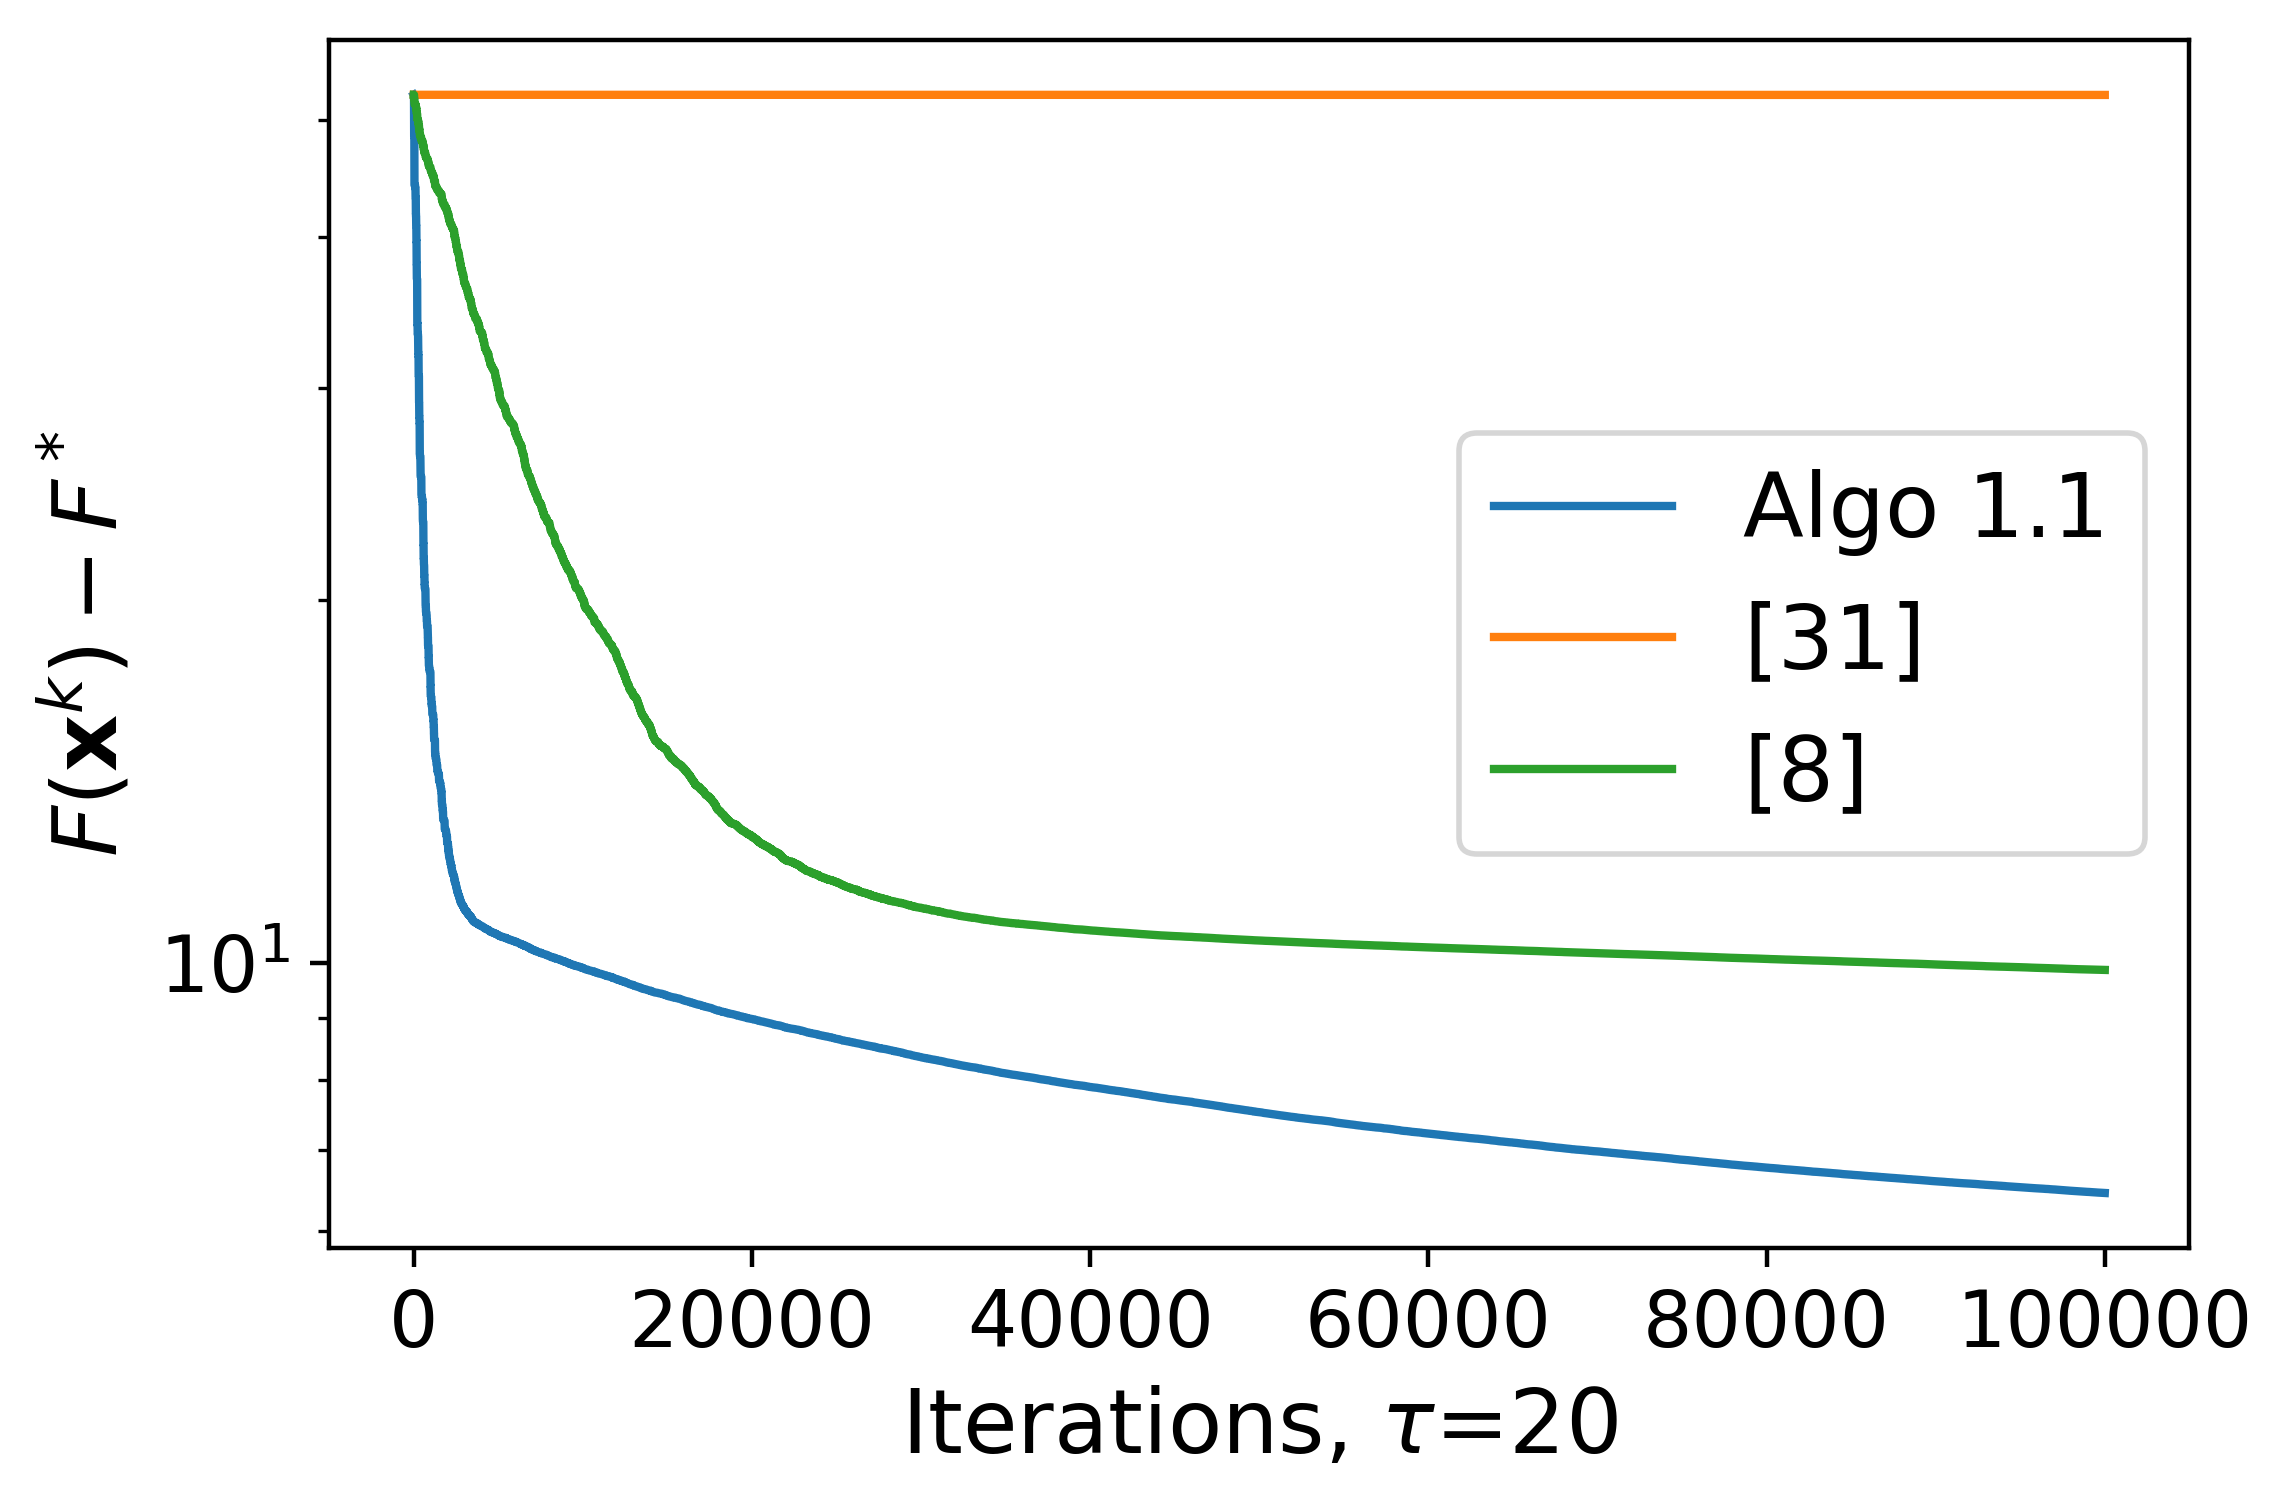

In [6]:
max_delay = 0
B = loadmat(f"data/pred/data_yearpred_train_all_together_{max_delay}.mat")
all_fx_reg, all_fx_lin_reg, all_fx_fach_reg, all_fx_wright_reg = B['all_fx'].reshape(B['all_fx'].shape[1]), \
        B['all_fx_lin'].reshape(B['all_fx'].shape[1]), B['all_fx_fach'].reshape(B['all_fx'].shape[1]), B['all_fx_wright'].reshape(B['all_fx'].shape[1])
f_star = min(all_fx_reg[-1], all_fx_lin_reg[-1])
for max_delay in [5,10,15,20]:
    B = loadmat(f"data/pred/data_yearpred_train_all_together_{max_delay}.mat")
    all_fx_reg, all_fx_lin_reg, all_fx_fach_reg, all_fx_wright_reg = B['all_fx'].reshape(B['all_fx'].shape[1]), \
            B['all_fx_lin'].reshape(B['all_fx'].shape[1]), B['all_fx_fach'].reshape(B['all_fx'].shape[1]), B['all_fx_wright'].reshape(B['all_fx'].shape[1])
    plt.figure(dpi=400)

    plt.semilogy(all_fx_lin_reg[:] - f_star, label=f"Algo 1.1")
    plt.semilogy(all_fx_wright_reg[:] - f_star, label=f"[31]")
    plt.semilogy(all_fx_fach_reg[:] - f_star, label=f"[8]")

    plt.ylabel("$F(\\mathbf{x}^k) - F^*$")
    plt.xlabel(f"Iterations, $\\tau$={max_delay}")
    plt.legend(loc='center right')#(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.savefig(f"fig_lasso_{max_delay}", format="png", bbox_inches='tight')

In [ ]:
A,b = load_svmlight_file("Classification/splice.t")

In [ ]:
A = A.toarray()

In [ ]:
n,m = A.shape

In [ ]:
lbda = 0.01

In [ ]:
l_res_log = (1./n) * norm(A, ord=2) * np.max(norm(A, ord=2, axis=0))
l_f_log = (1./n) * np.max(norm(A, ord=2, axis=0)) * norm(A, ord='fro')
l_max_log = (1./n) * norm(A, ord=np.inf) * np.max(norm(A, ord=np.inf, axis=1)) # np.max(np.max(np.abs(A), axis=1))
LMDA_log = l_res_log / l_max_log

rho_log = (1.0001 + 4/np.sqrt(m)) / (1. - 16./m)

stepsizes = np.zeros((4,3))

max_iter = 100000

for max_delay in [0,5,10,15,20]:
    stepsize_log = .5*( (1./n)*norm(A, ord=2, axis=0)**2 + (2*max_delay*l_res_log/np.sqrt(m)) )
    stepsize_lin_log = .5*( (1./n)*norm(A, ord=2, axis=0)**2 + (2*max_delay*l_res_log) )

    fach_stepsize_log = (l_f_log + .5*(max_delay**2)*l_f_log) * np.ones(m) # (2.*l_f_log + (max_delay**2.)*l_f_log) * np.ones(m) # 

    theta_log = (rho_log**((max_delay+1)/2) - rho_log**.5) / (rho_log**.5 - 1)
    theta_prime_log = (rho_log**(max_delay+1) - rho_log) / (rho_log - 1)
    phi_log = 1 + max_delay*theta_prime_log/m + 2*LMDA_log*theta_log/(np.sqrt(m))
    tmp_log =  (4*LMDA_log*(1+theta_log)) / (np.sqrt(m)*(1 - 1/rho_log) - 4) 
    wright_stepsize_log = max(l_max_log*phi_log, l_max_log*tmp_log)*np.ones(m)

    stepsizes[int(max_delay/5) - 1] = np.array([min(1./stepsize_log), 1./fach_stepsize_log[0], 1./wright_stepsize_log[0]]).reshape(1,3)

    all_fx_log, all_fx_lin_log, all_fx_fach_log, all_fx_wright_log= RBCFB_Logistic(A, b, lbda, max_iter, stepsize_log, stepsize_lin_log, fach_stepsize_log, wright_stepsize_log, n_block=1, max_delay=max_delay)
    mdic = {"all_fx_log": all_fx_log, "all_fx_lin_log":all_fx_lin_log, "all_fx_fach_log":all_fx_fach_log, "all_fx_wright_log":all_fx_wright_log, "tau":max_delay, "label": "Data"}
    savemat(f"data/class/data_splice_train_all_together_{max_delay}.mat", mdic)

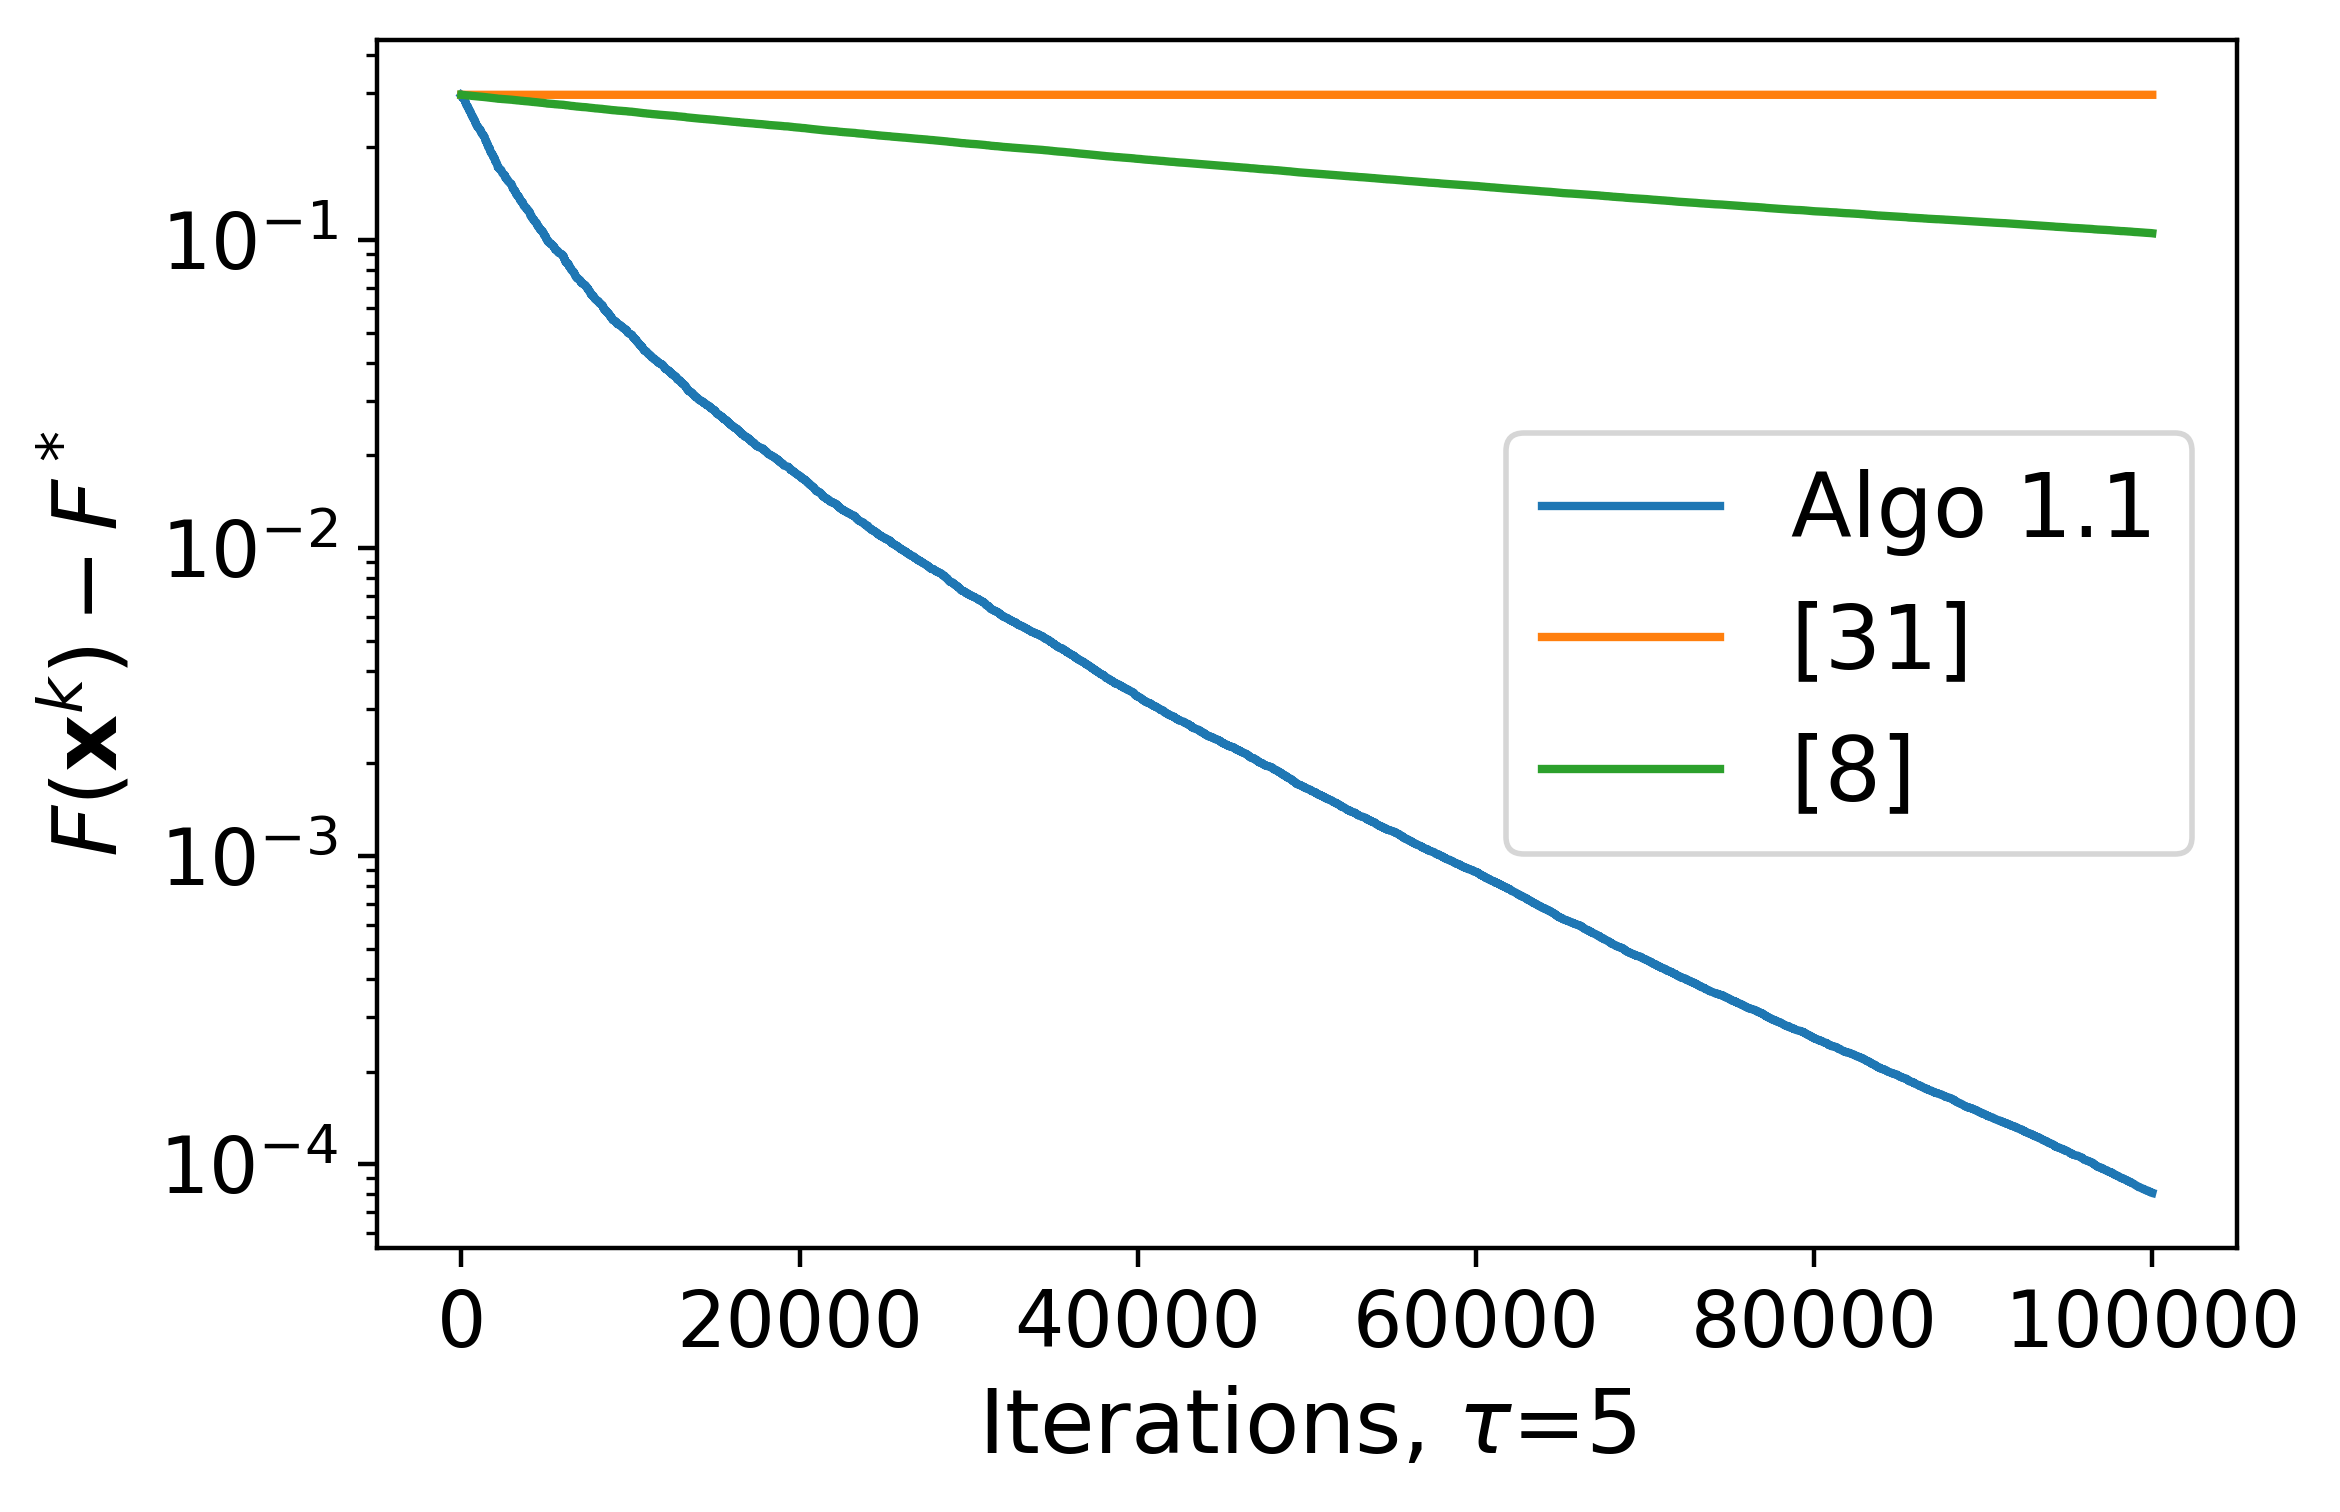

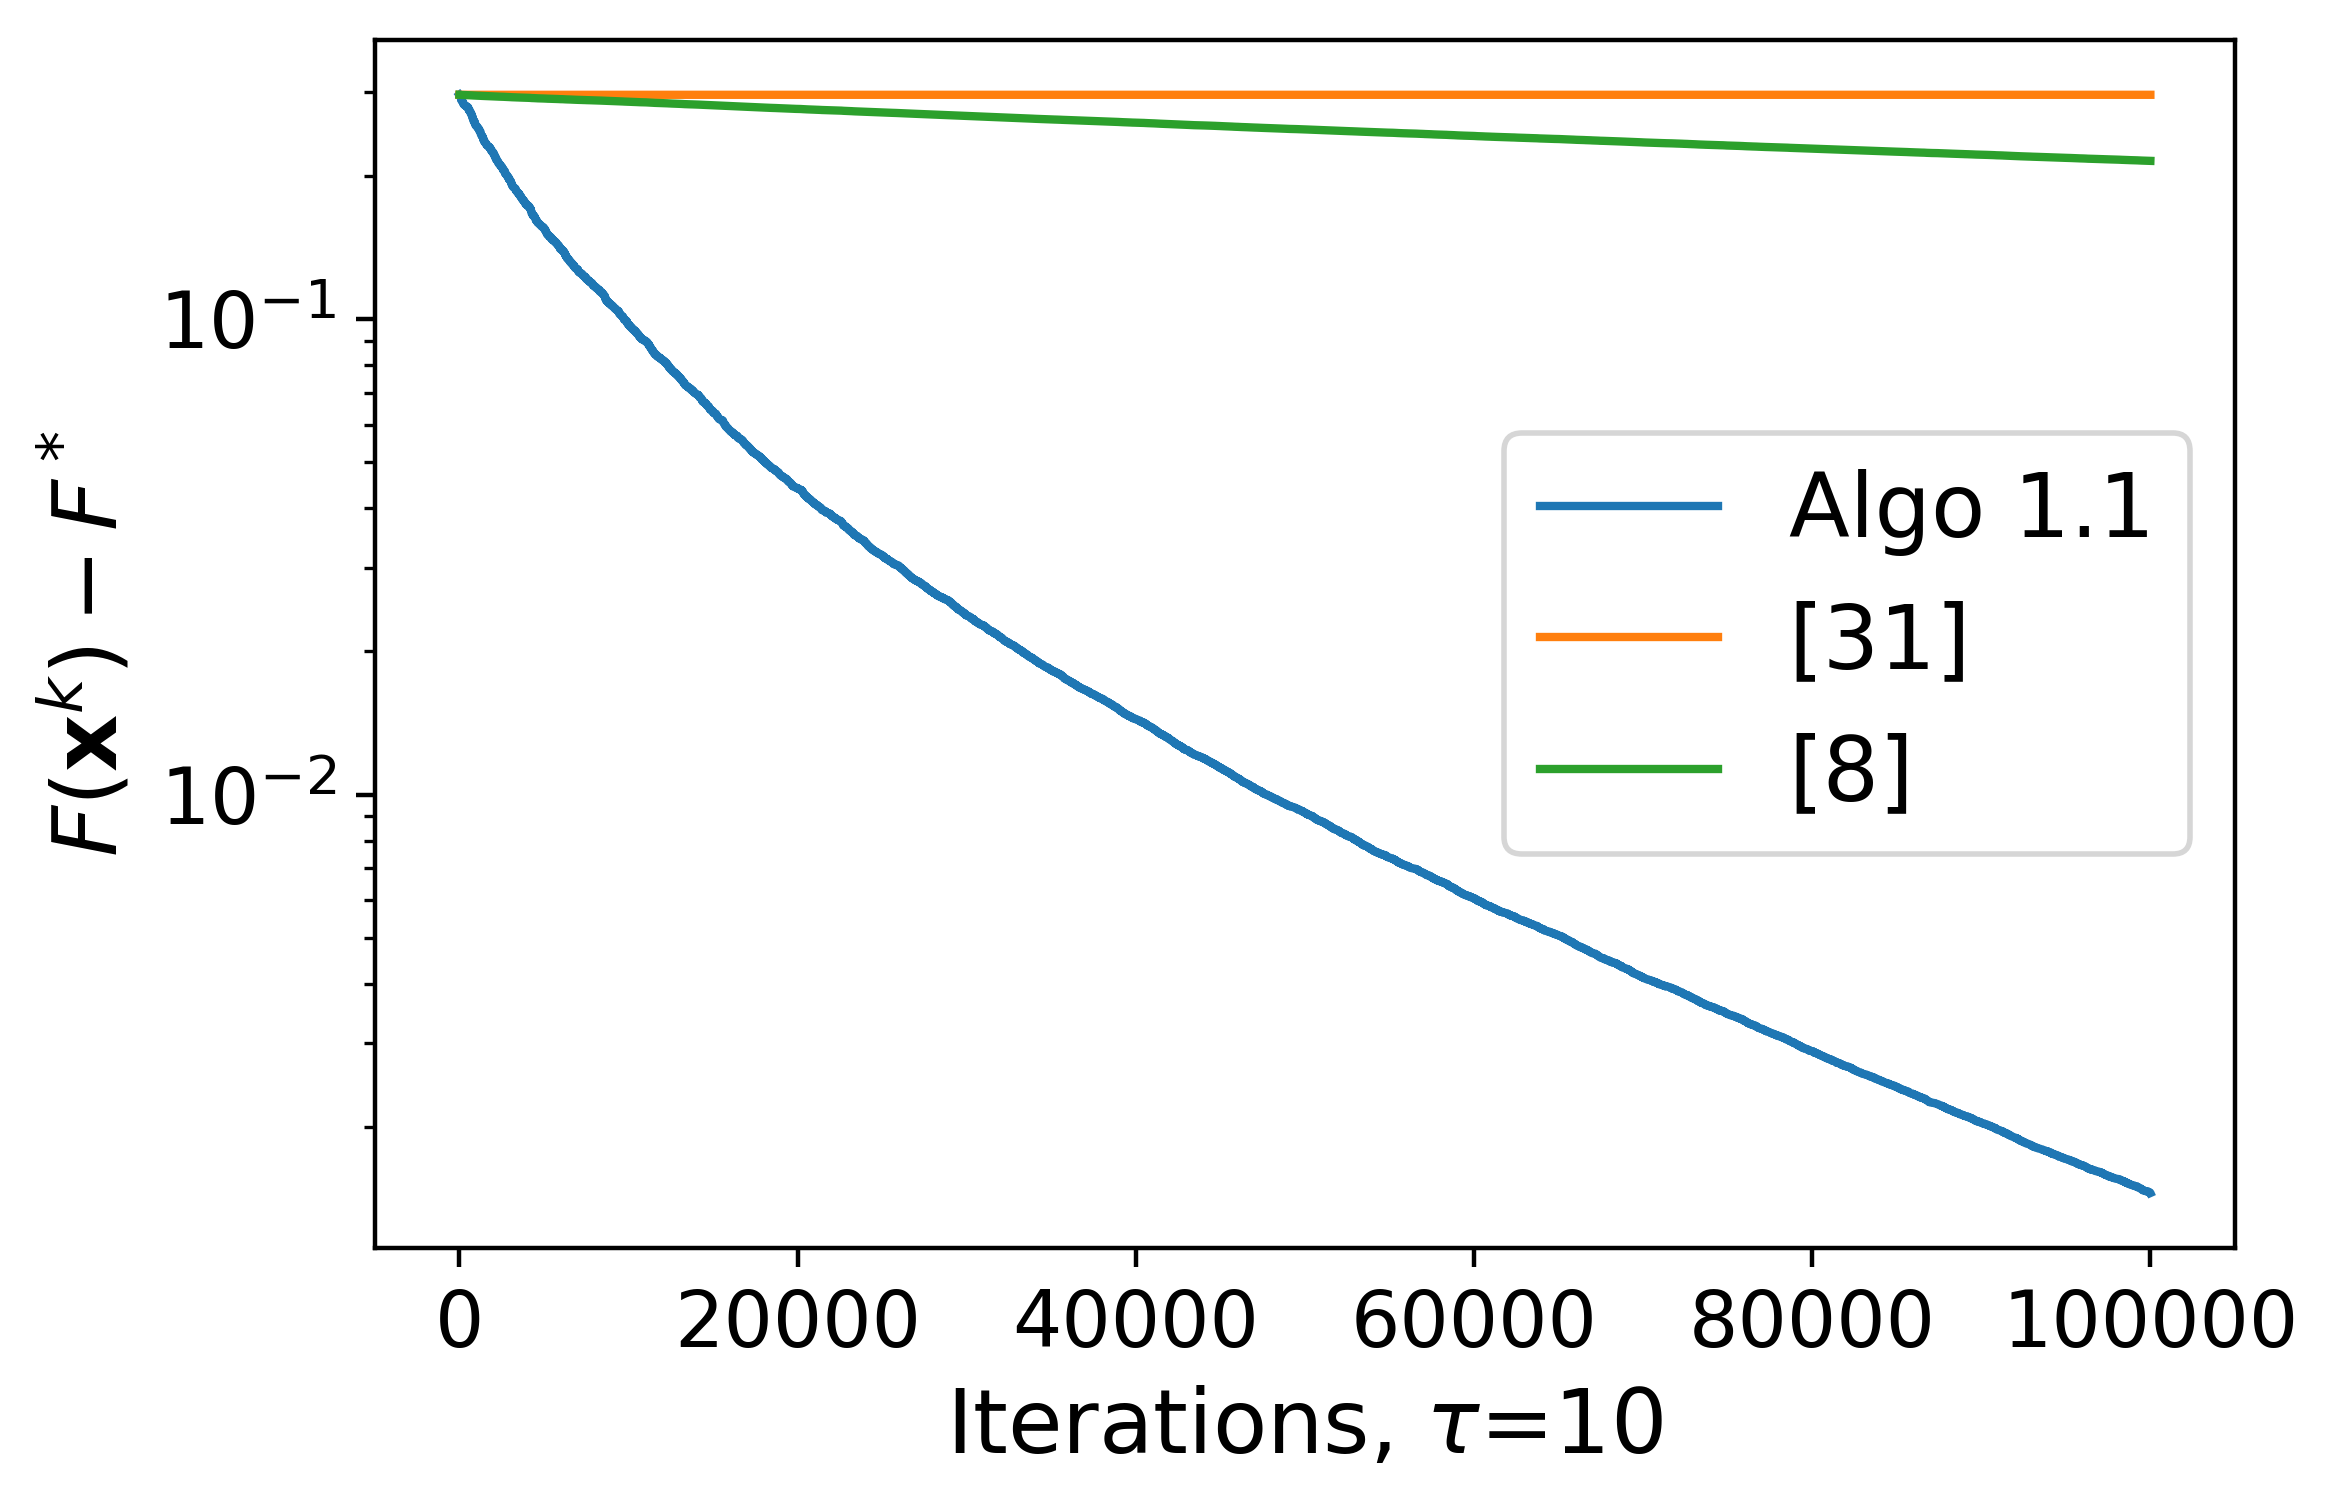

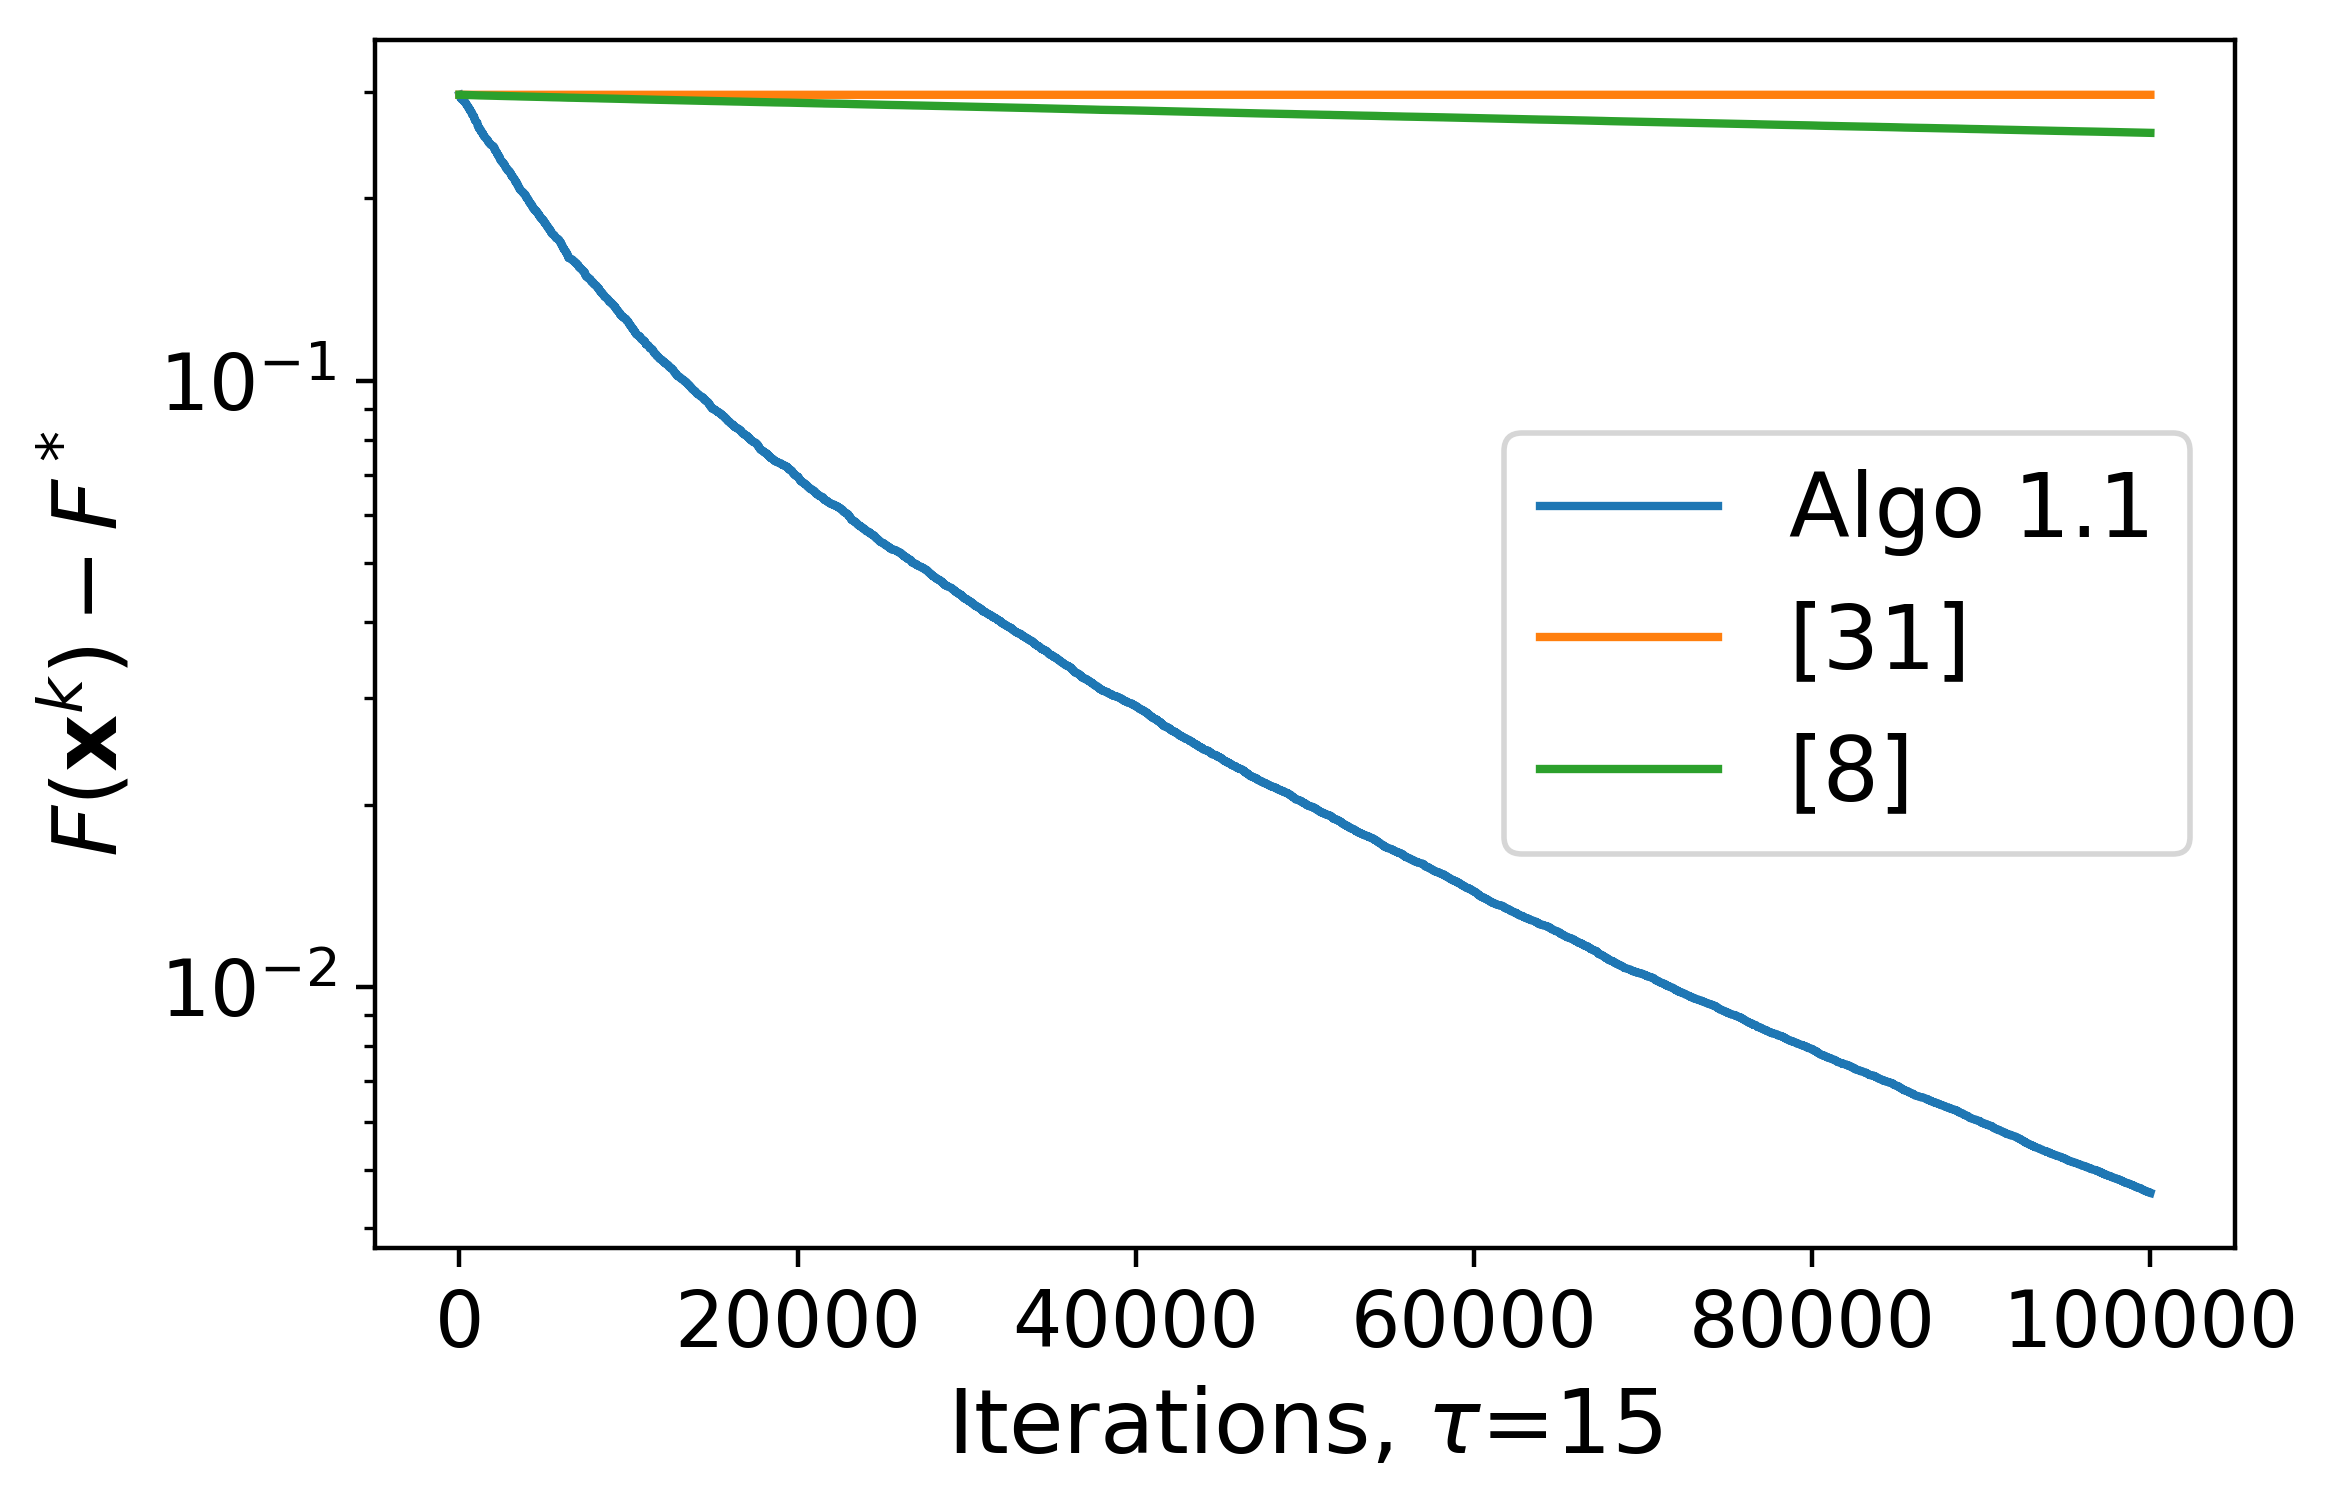

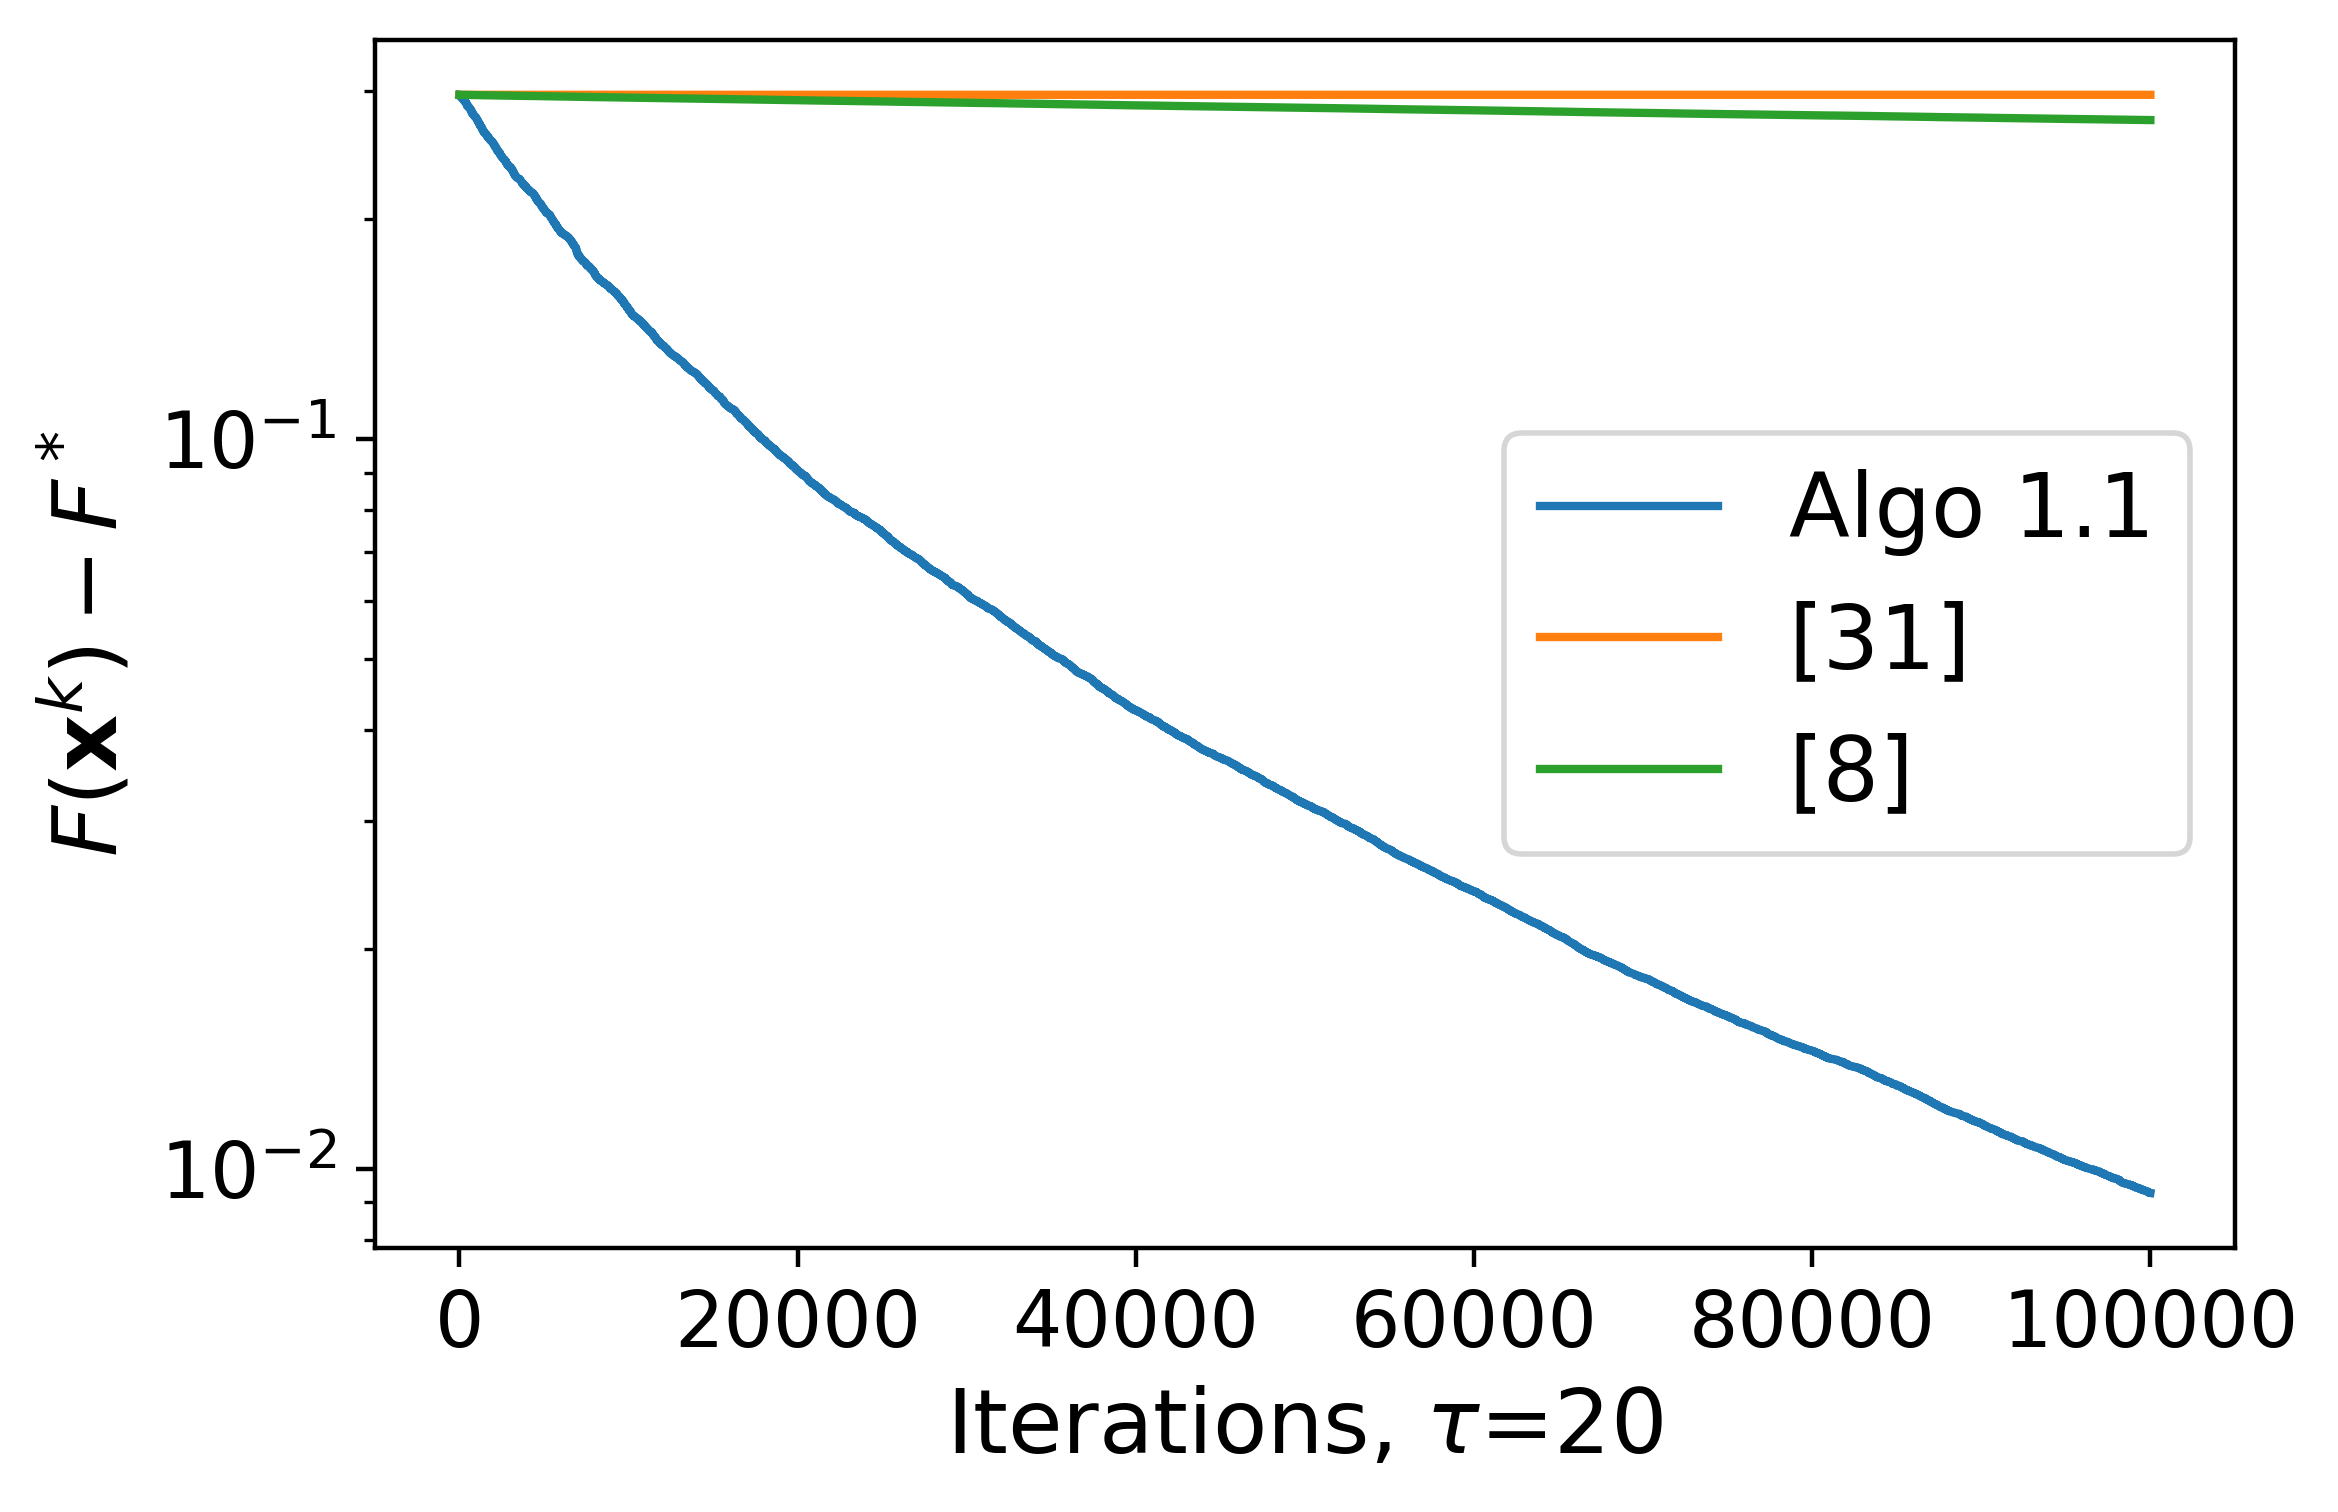

In [7]:
max_delay = 0
B = loadmat(f"data/class/data_splice_train_all_together_{max_delay}.mat")
all_fx_log, all_fx_lin_log, all_fx_fach_log, all_fx_wright_log = B['all_fx_log'].reshape(B['all_fx_log'].shape[1]), \
        B['all_fx_lin_log'].reshape(B['all_fx_log'].shape[1]), B['all_fx_fach_log'].reshape(B['all_fx_log'].shape[1]),\
        B['all_fx_wright_log'].reshape(B['all_fx_log'].shape[1])
f_star = min(all_fx_lin_log[-1], all_fx_log[-1])
for max_delay in [5,10,15,20]:
    B = loadmat(f"data/class/data_splice_train_all_together_{max_delay}.mat")
    all_fx_log, all_fx_lin_log, all_fx_fach_log, all_fx_wright_log = B['all_fx_log'].reshape(B['all_fx_log'].shape[1]), \
            B['all_fx_lin_log'].reshape(B['all_fx_log'].shape[1]), B['all_fx_fach_log'].reshape(B['all_fx_log'].shape[1]),\
            B['all_fx_wright_log'].reshape(B['all_fx_log'].shape[1])
    
    plt.figure(dpi=400)

    plt.semilogy(all_fx_log[:] - f_star, label=f"Algo 1.1")
    plt.semilogy(all_fx_wright_log[:] - f_star, label=f"[31]")#, marker="+")
    plt.semilogy(all_fx_fach_log[:] - f_star, label=f"[8]")

    plt.ylabel("$F(\\mathbf{x}^k) - F^*$")
    plt.xlabel(f"Iterations, $\\tau$={max_delay}")
    plt.legend(loc='center right')#(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.savefig(f"fig_logistic_{max_delay}", format="png", bbox_inches='tight')